In [1]:
import dask.dataframe as dd
from dask.distributed import Client

c = Client('localhost:8786')

In [2]:
c.restart()

<Client: scheduler='tcp://localhost:8786' processes=4 cores=4>

In [3]:
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

import seaborn.apionly as sns
from matplotlib import rcParams

import matplotlib.dates as mdates
from matplotlib.colors import SymLogNorm as symlog

In [5]:
plt.style.use('seaborn-darkgrid')

rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 10
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'
rcParams['axes.titlesize'] = 11

rcParams['savefig.dpi'] = 150
rcParams['figure.dpi'] = 150

rcParams['grid.color'] = 'w'
rcParams['grid.alpha'] = 0.7

rcParams['xtick.direction'] = 'out'
rcParams['xtick.major.size'] = 3
rcParams['ytick.direction'] = 'out'
rcParams['ytick.major.size'] = 3




import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

# Pickups

In [6]:
pickups = dd.read_parquet('/data/NYC_taxi_2009-2016.parquet', engine='arrow', 
                        columns=['pickup_datetime', 'pickup_taxizone_id', 'trip_type'])
pickups = pickups[pickups.trip_type != 'uber']

In [7]:
pickups = pickups.drop('trip_type', axis=1)

In [8]:
pickups.columns = ['t', 'id']

In [9]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
pickups['timeofday'] = (pickups.t.dt.hour + (pickups.t.dt.minute // 6)/10)

In [10]:
pickups['dayofweek'] = pickups.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
pickups['weeks_since_2009'] = (pickups.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [11]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

pickups['isbusday'] = pickups.map_partitions(isbusday, meta=(None, int))

In [12]:
# pickups = pickups[(pickups.isbusday == 1) | (pickups.dayofweek > 4)]

In [13]:
pickups.tail()

t   id  timeofday  dayofweek  weeks_since_2009  \
1432504 2016-12-31 23:59:57   36       23.9          5               417   
1432505 2016-12-31 23:59:58   76       23.9          5               417   
1432506 2016-12-31 23:59:58  168       23.9          5               417   
1432507 2016-12-31 23:59:58  144       23.9          5               417   
1432508 2016-12-31 23:59:59  135       23.9          5               417   

         isbusday  
1432504         0  
1432505         0  
1432506         0  
1432507         0  
1432508         0

In [14]:
heatmap_all_pickups = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_pickups_std = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [15]:
heatmap_all_pickups.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_pickups_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

# Dropoffs

In [16]:
dropoffs = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                        columns=['dropoff_datetime', 'dropoff_taxizone_id', 'trip_type'])
dropoffs = dropoffs[dropoffs.trip_type != 'uber']

In [17]:
dropoffs = dropoffs.drop('trip_type', axis=1)

In [18]:
dropoffs.columns = ['t', 'id']

In [19]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
dropoffs['timeofday'] = (dropoffs.t.dt.hour + (dropoffs.t.dt.minute // 6)/10)

In [20]:
dropoffs['dayofweek'] = dropoffs.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
dropoffs['weeks_since_2009'] = (dropoffs.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [21]:
dropoffs = dropoffs[dropoffs.weeks_since_2009 > 0]

In [22]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

dropoffs['isbusday'] = dropoffs.map_partitions(isbusday, meta=(None, int))

In [23]:
# dropoffs = dropoffs[(dropoffs.isbusday == 1) | (dropoffs.dayofweek > 4)]

In [24]:
dropoffs.tail()

t   id  timeofday  dayofweek  weeks_since_2009  \
1432504 2017-01-01 00:07:47   36        0.1          6               417   
1432505 2017-01-01 00:15:29   63        0.2          6               417   
1432506 2017-01-01 00:39:07  161        0.6          6               417   
1432507 2017-01-01 00:03:50  209        0.0          6               417   
1432508 2017-01-01 00:14:30  134        0.2          6               417   

         isbusday  
1432504         0  
1432505         0  
1432506         0  
1432507         0  
1432508         0

In [25]:
heatmap_all_dropoffs = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_dropoffs_std = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [26]:
heatmap_all_dropoffs.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_dropoffs_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

# Plotting

In [148]:
!mkdir 04_temporal_figures

In [27]:
pickup_counts = np.zeros((7, 240), dtype=np.float32) 
dropoff_counts = np.zeros((7, 240), dtype=np.float32) 

pickup_counts_std = np.zeros((7, 240), dtype=np.float32) 
dropoff_counts_std = np.zeros((7, 240), dtype=np.float32) 

for weekday in range(7):
    pickup_counts[weekday, :] = heatmap_all_pickups[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts[weekday, :] = heatmap_all_dropoffs[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same
    
    pickup_counts_std[weekday, :] = heatmap_all_pickups_std[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts_std[weekday, :] = heatmap_all_dropoffs_std[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same

In [28]:
pickup_counts = np.roll(pickup_counts.ravel(), -60).reshape(pickup_counts.shape)
dropoff_counts = np.roll(dropoff_counts.ravel(), -60).reshape(dropoff_counts.shape)
pickup_counts_std = np.roll(pickup_counts_std.ravel(), -60).reshape(pickup_counts_std.shape)
dropoff_counts_std = np.roll(dropoff_counts_std.ravel(), -60).reshape(dropoff_counts_std.shape)

In [29]:
from skimage import exposure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [30]:
# p2, p98 = np.percentile(pickup_counts/pickup_counts.sum(), (2, 98))
# img_rescale = exposure.rescale_intensity(counts/counts.sum(), in_range=(p2, p98))
pickups_rescaled = exposure.equalize_hist(pickup_counts)
dropoffs_rescaled = exposure.equalize_hist(dropoff_counts)


pickups_rescaled_std = exposure.equalize_hist(pickup_counts_std)
dropoffs_rescaled_std = exposure.equalize_hist(dropoff_counts_std)

# pickups_rescaled = pickup_counts
# dropoffs_rescaled = dropoff_counts

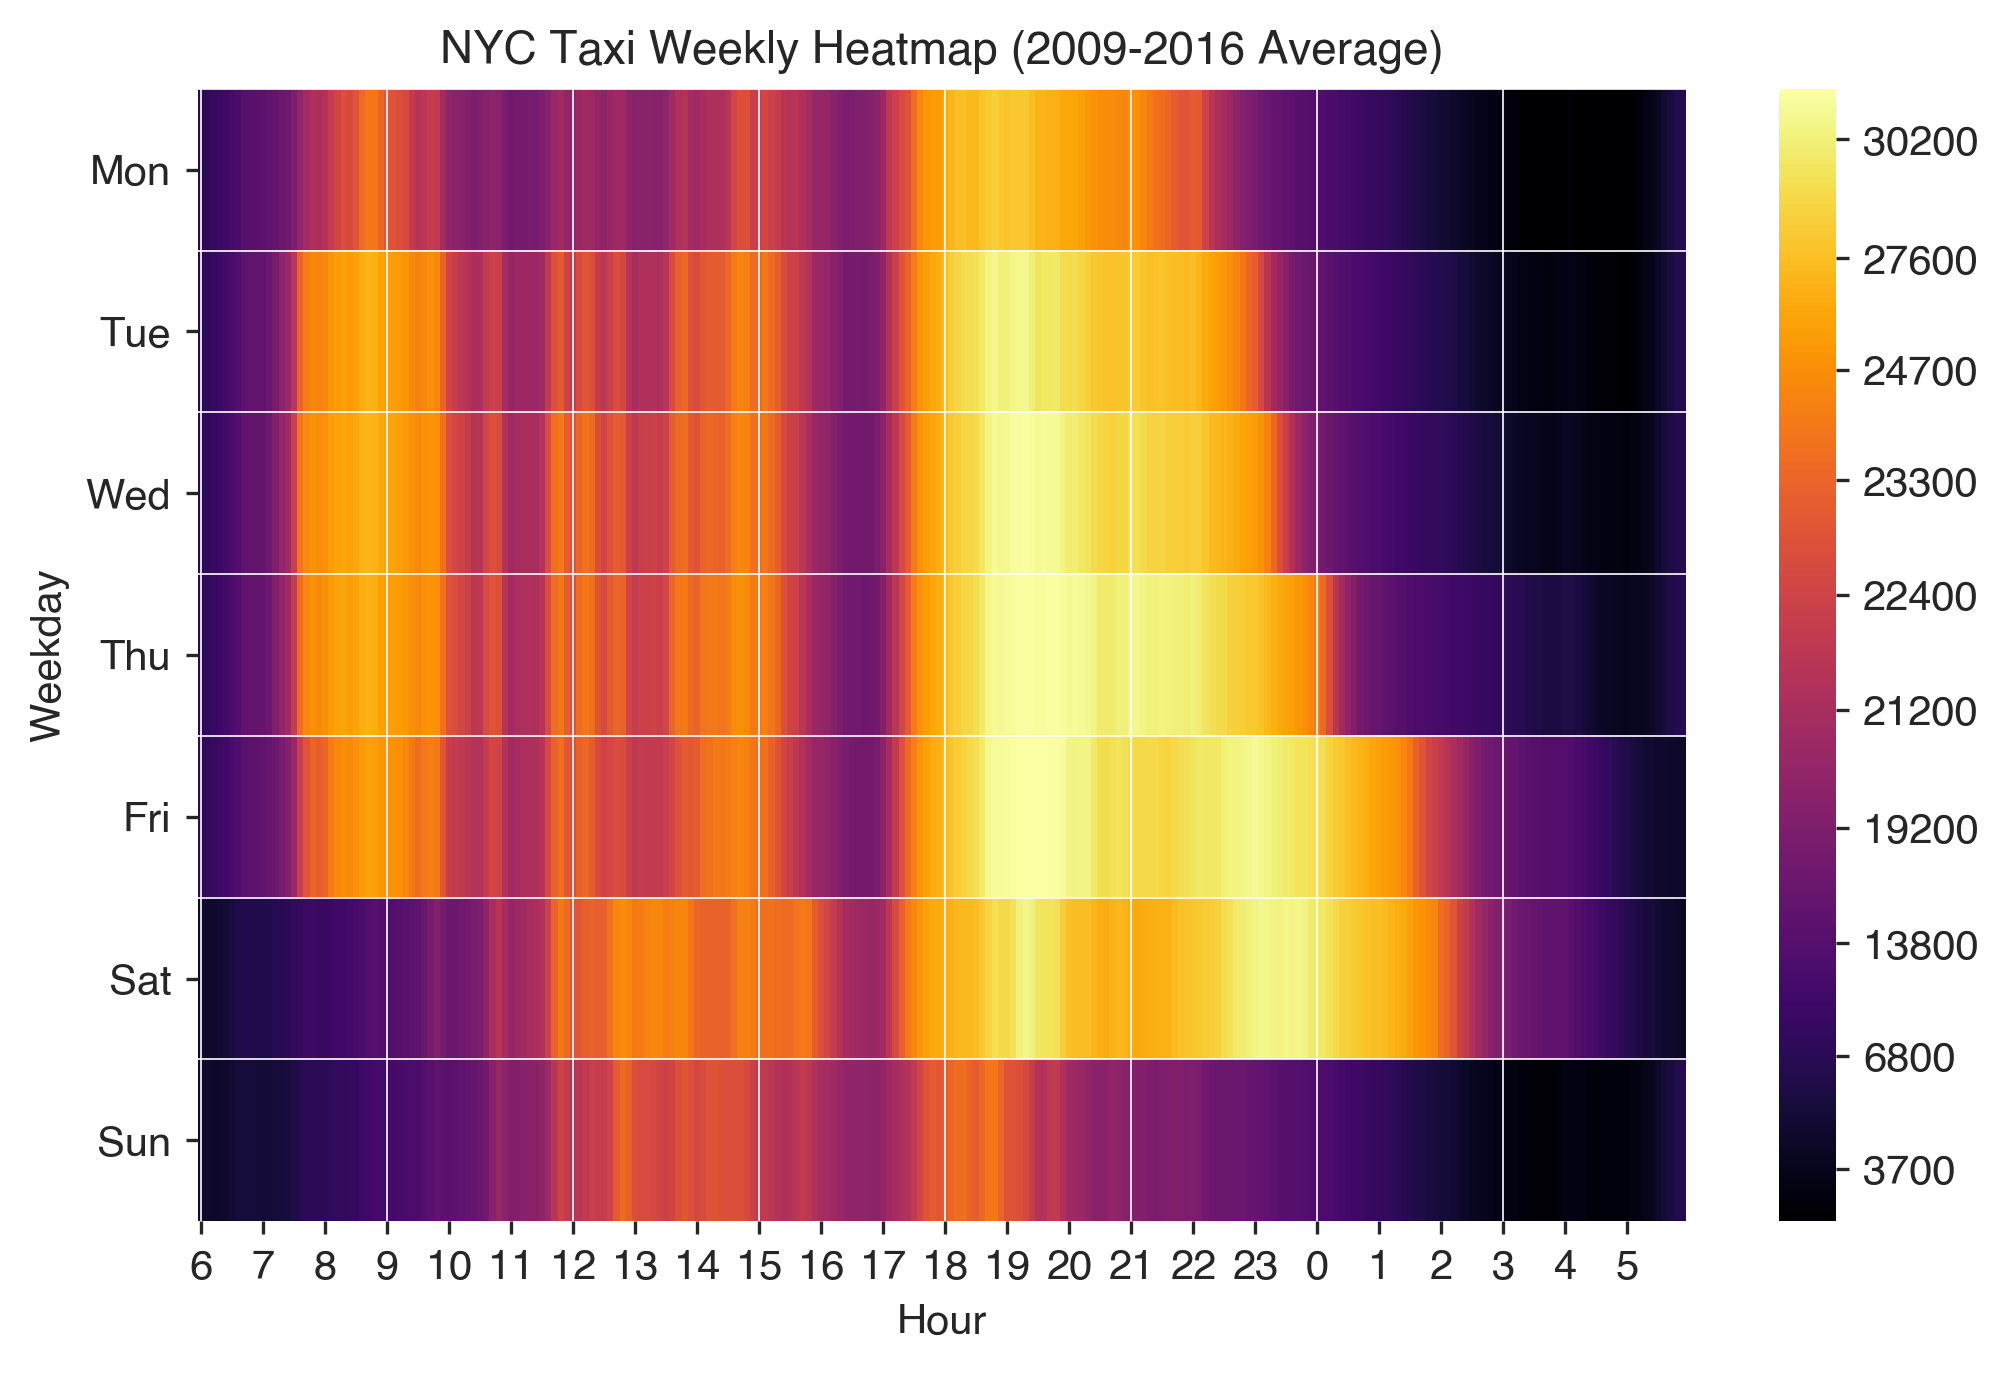

In [150]:
plt.imshow(pickups_rescaled, aspect='auto', interpolation='none', cmap=plt.cm.inferno)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
cb.set_ticks(np.percentile(pickups_rescaled.ravel(), q=np.arange(5, 100, 10)))
cb.set_ticklabels((np.percentile(pickup_counts.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 240, 30):
    plt.axvline(i, color='w', lw=0.4)
    
    
plt.title("NYC Taxi Weekly Heatmap (2009-2016 Average)")
plt.savefig('04_temporal_figures/weekly_pickups_heatmap.png', dpi=300)

(0, 240)

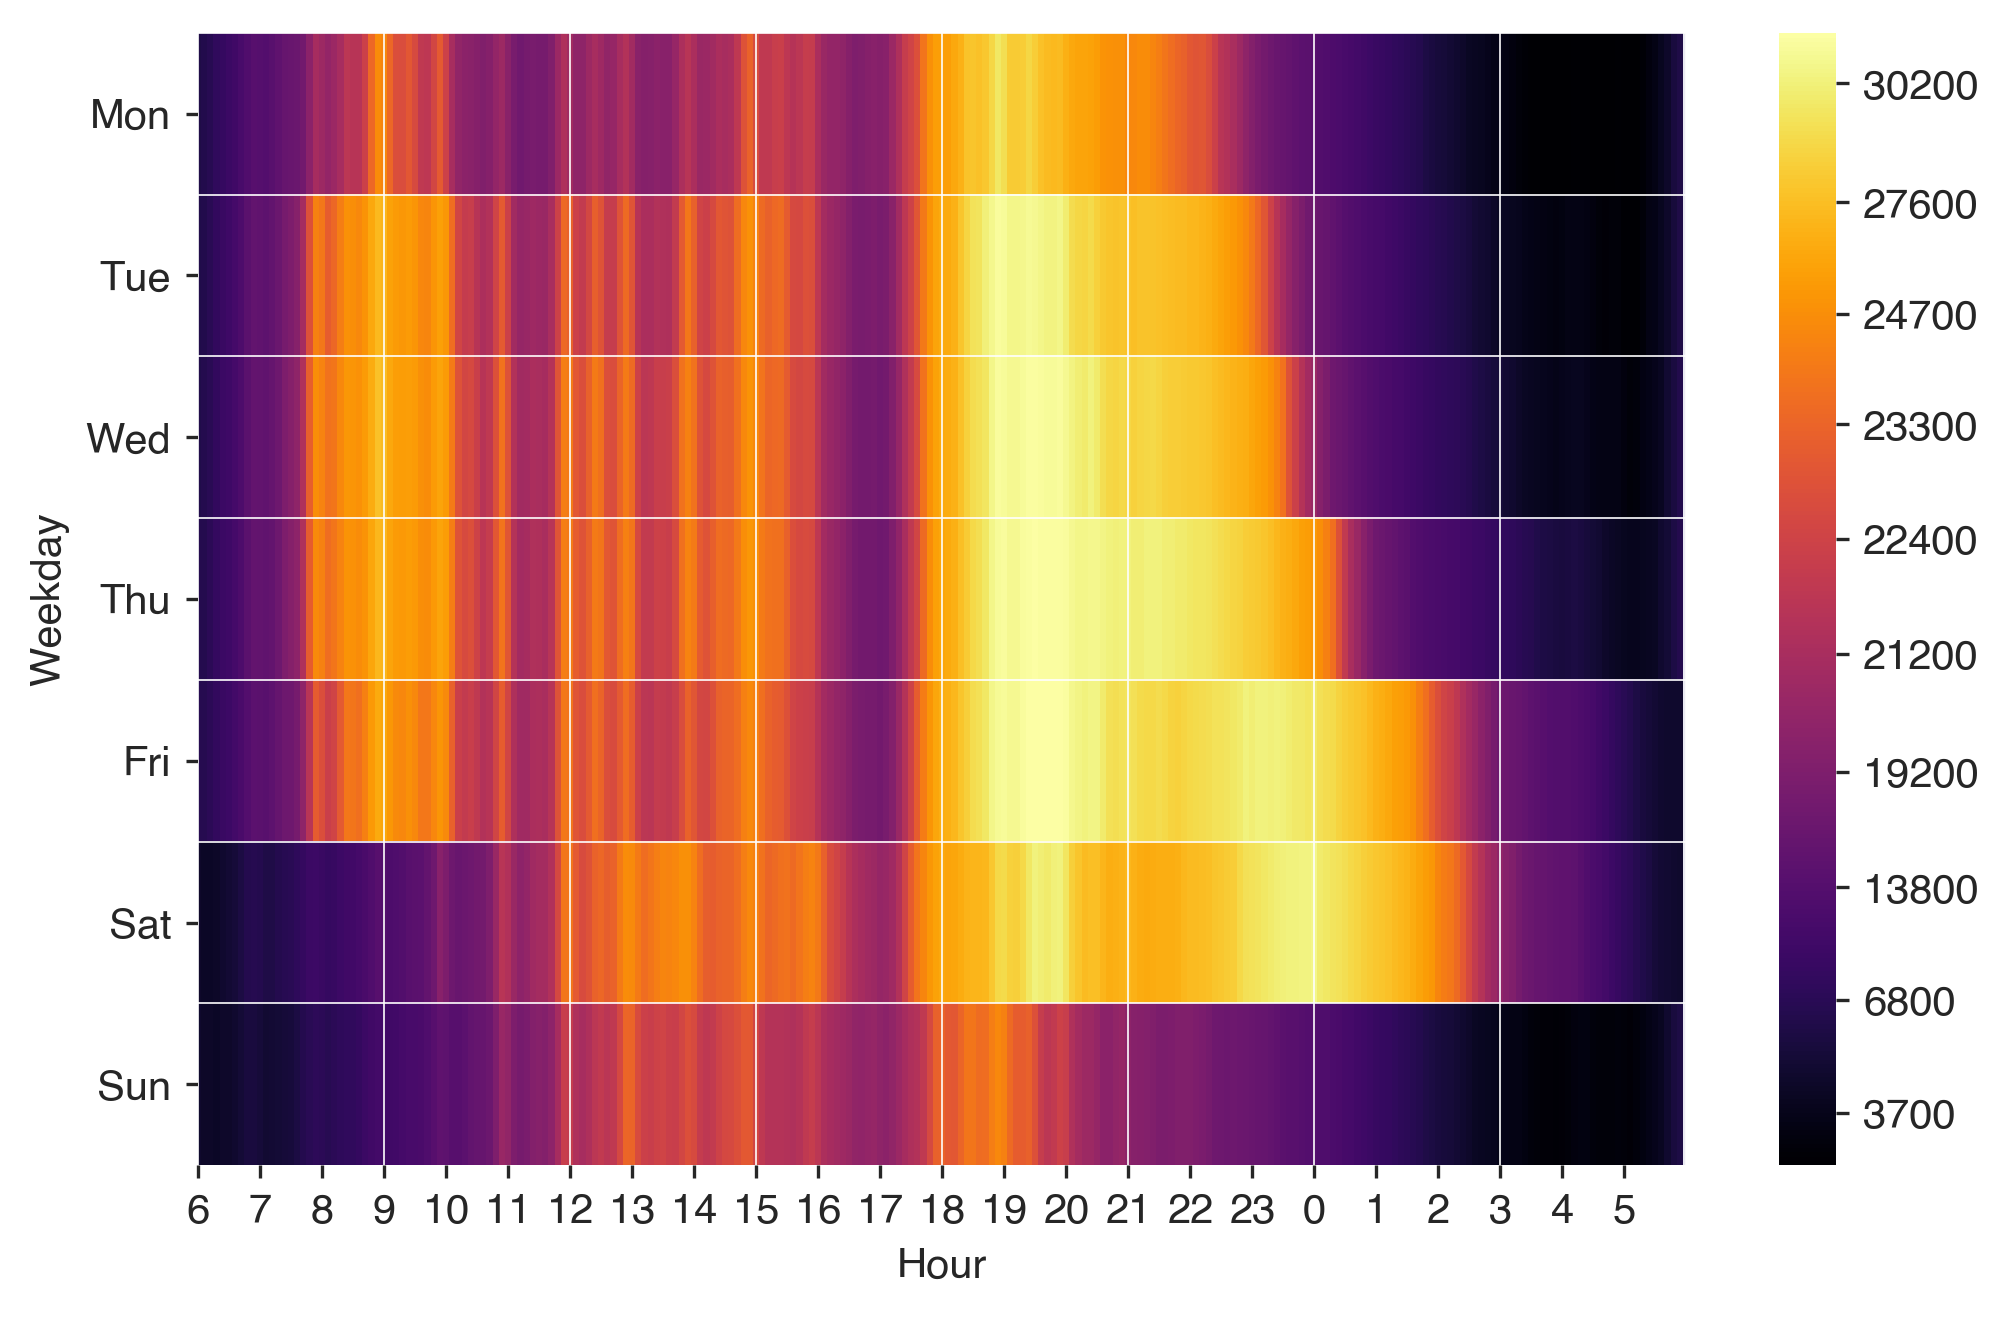

In [112]:
plt.imshow(dropoffs_rescaled, aspect='auto', interpolation='none', cmap=plt.cm.inferno)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
cb.set_ticks(np.percentile(pickups_rescaled.ravel(), q=np.arange(5, 100, 10)))
cb.set_ticklabels((np.percentile(pickup_counts.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='2', lw=0.4)
plt.xlim(0, 240)

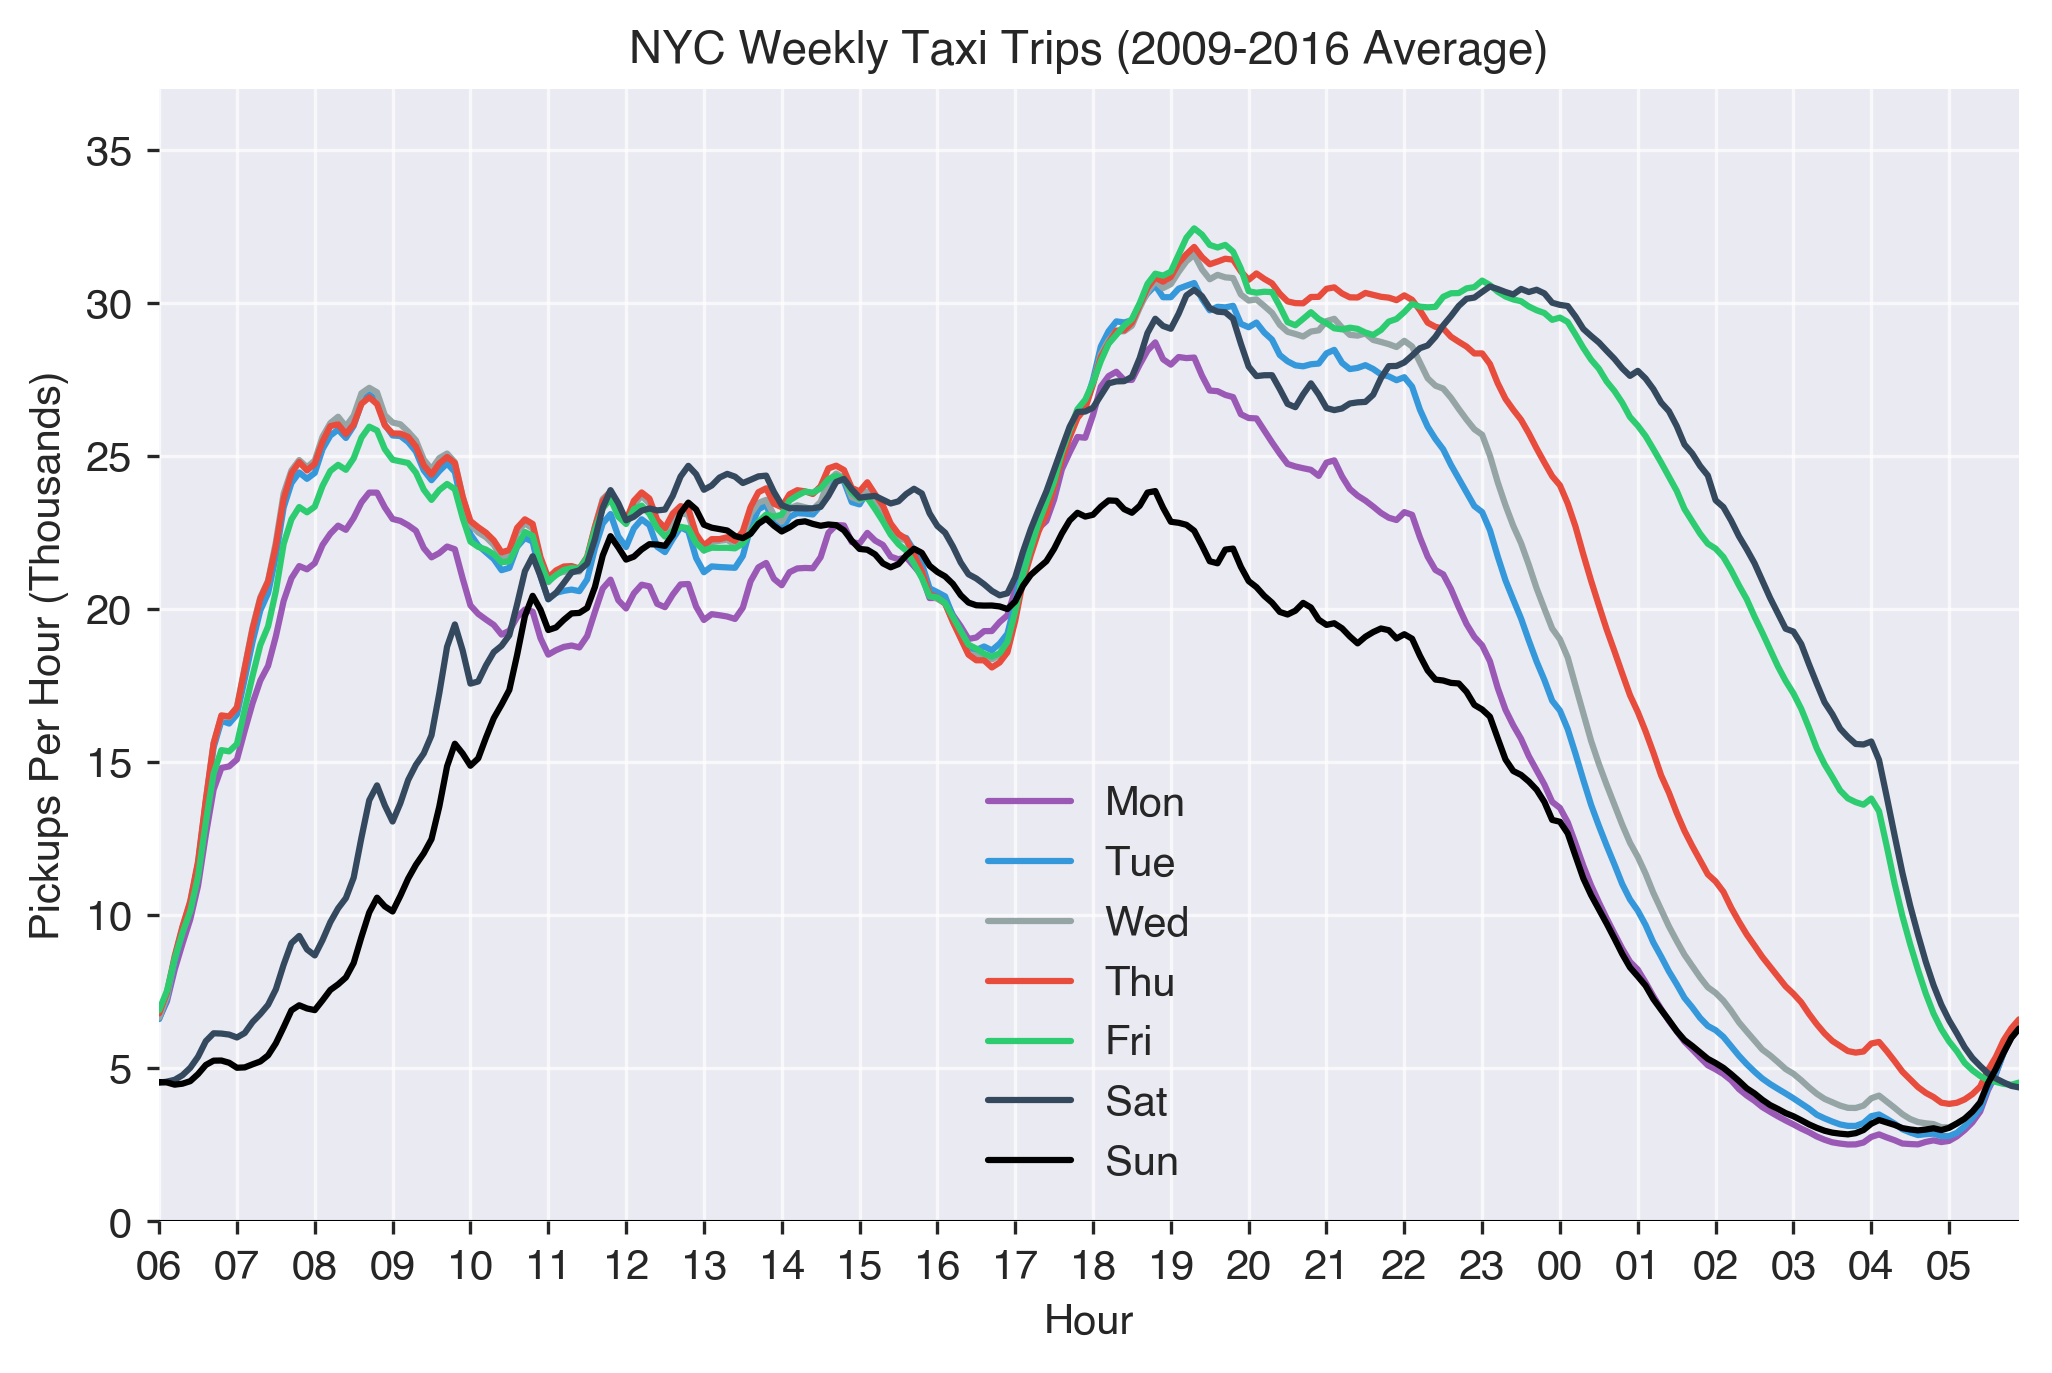

In [151]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, 0.001*(pickup_counts)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='lower center')
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))
plt.ylim(0, 37)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour (Thousands)")
plt.title("NYC Weekly Taxi Trips (2009-2016 Average)")

plt.savefig('04_temporal_figures/weekly_pickups_lines.png', dpi=300)

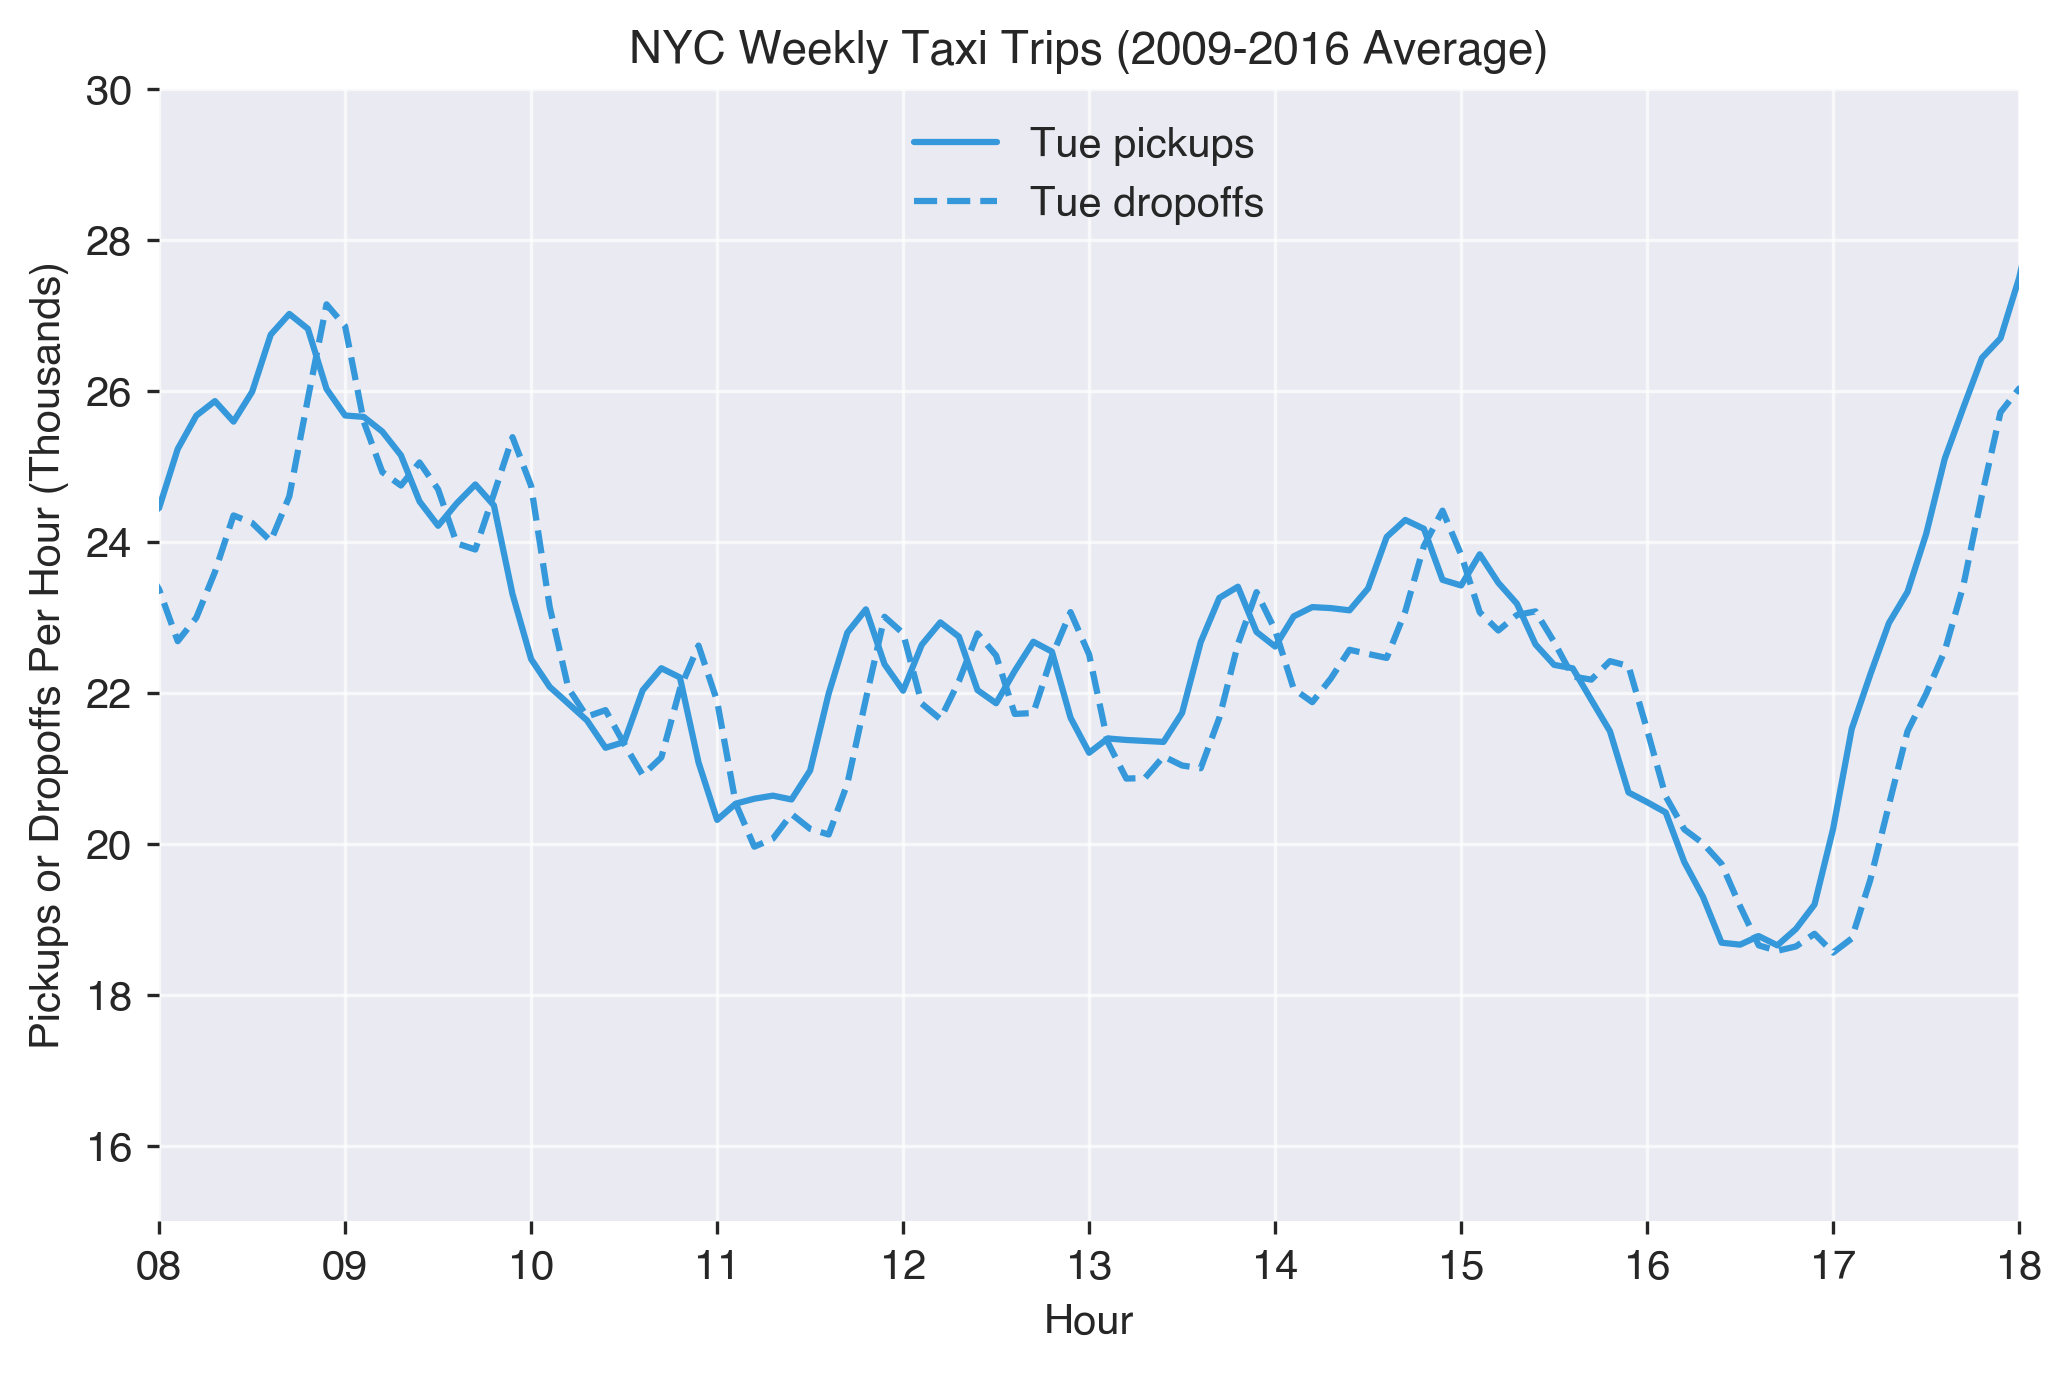

In [152]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    if i== 1:
        plt.plot(xv, 0.001*(pickup_counts)[i], label=day + " pickups", color=palette[i])
        plt.plot(xv, 0.001*(dropoff_counts)[i], label=day + " dropoffs", color=palette[i], linestyle='--')

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 08:00:00', '2009-01-01 18:00:00')
plt.legend(loc='upper center')
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 08:00:00', '2009-01-01 18:00:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 08:00:00', '2009-01-01 18:00:00', freq='H').strftime('%H'))
plt.ylim(15, 30)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups or Dropoffs Per Hour (Thousands)")
plt.title("NYC Weekly Taxi Trips (2009-2016 Average)")

plt.savefig('04_temporal_figures/weekly_pickups_lines_tuesday.png', dpi=300)

In [34]:
import scipy.stats
scipy.stats.describe((pickup_counts - dropoff_counts).ravel())

DescribeResult(nobs=1680, minmax=(-2293.6172, 4044.457), mean=286.418, variance=1023736.9, skewness=0.6254827380180359, kurtosis=0.41857570138961364)

(0, 240)

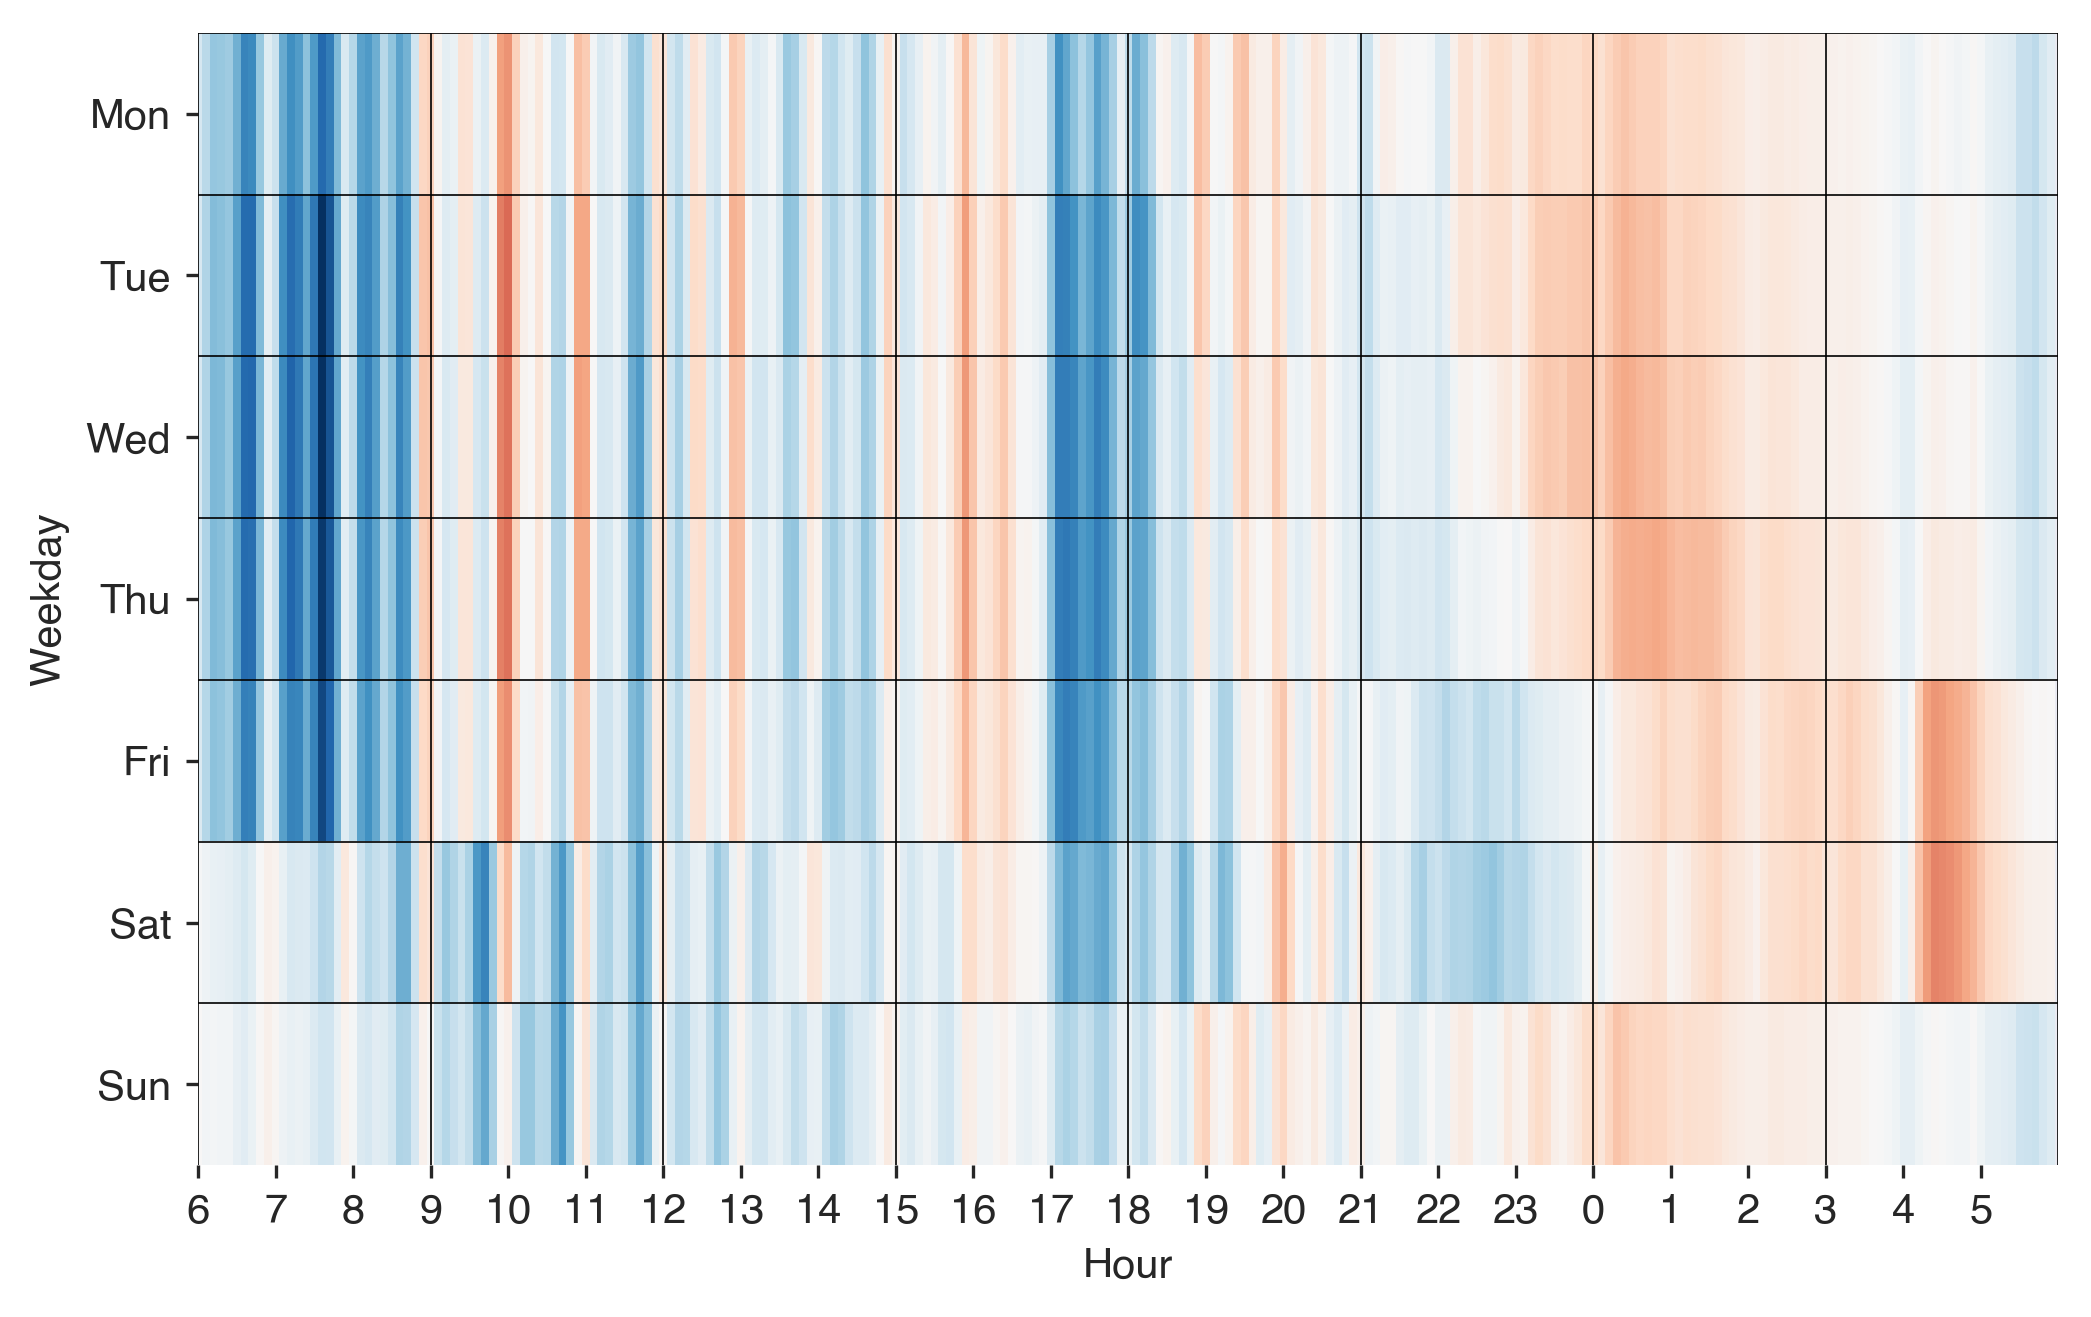

In [35]:
plt.imshow(pickup_counts - dropoff_counts, aspect='auto', cmap=plt.cm.RdBu, vmin=-4041, vmax=4041)
plt.gcf().set_size_inches(8, 5)

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

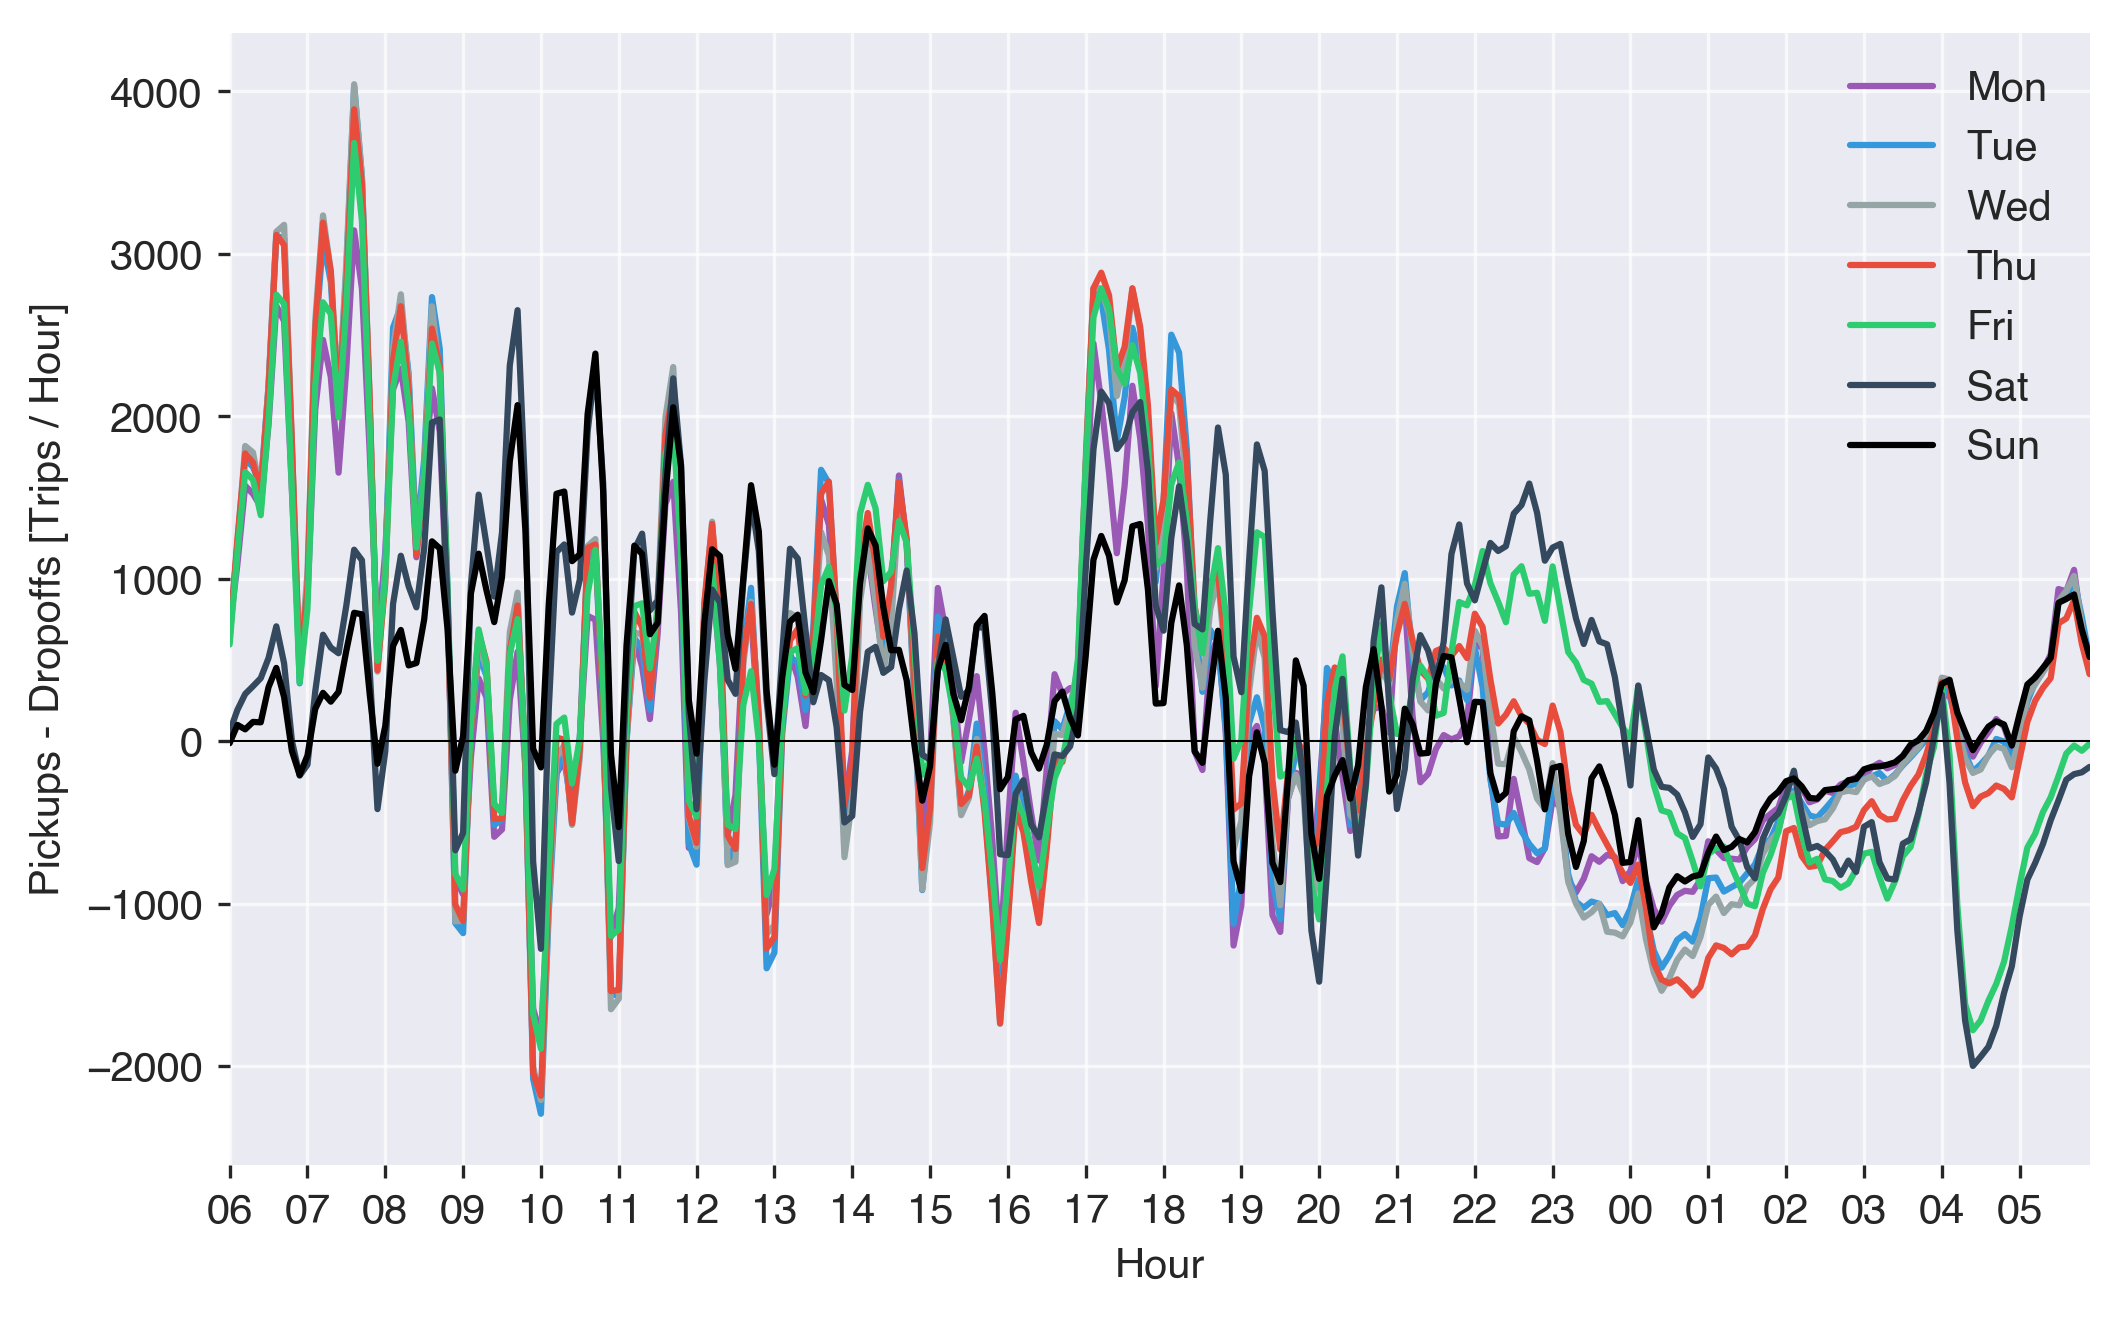

In [115]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, (pickup_counts-dropoff_counts)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='upper right')

plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))

plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups - Dropoffs [Trips / Hour]")

# Pickup Trends

In [37]:
heatmap_all_pickups_all = (pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']] \
                            .groupby(['dayofweek', 'timeofday', 'weeks_since_2009']).count().compute())

In [39]:
import statsmodels.api as sm

/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [81]:
grouped = heatmap_all_pickups_all.reset_index().groupby(['dayofweek', 'timeofday'])

rows = []

for group in grouped.groups.keys():
    df = grouped.get_group(group)
    df['constant']=1
    X = df[['weeks_since_2009','constant']]
    y = df['id']
    model = sm.OLS(y,X)
    results = model.fit()
    
    rows.append(group + (results.params.weeks_since_2009, results.params.constant, 
                         results.rsquared_adj, results.pvalues.weeks_since_2009))


/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [90]:
df_pickup_trend_slopes = pd.DataFrame.from_records(
    rows, columns=['dayofweek', 'timeofday', 'slope', 'intercept', 'rsq_adj', 'pvalue']
                                                  ).sort_values(['dayofweek', 'timeofday'])

In [91]:
pickup_trends = np.zeros((7, 240), dtype=np.float32) 
pickup_trends_rsq_adj = np.zeros((7, 240), dtype=np.float32)
pickup_trends_pvalue = np.zeros((7, 240), dtype=np.float32)

for weekday in range(7):
    pickup_trends[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].slope.values * 10 * 52 # convert units into counts per hour
    pickup_trends_rsq_adj[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].rsq_adj.values
    pickup_trends_pvalue[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].pvalue.values
    
pickup_trends = np.roll(pickup_trends.ravel(), -60).reshape(pickup_trends.shape)
pickup_trends_rsq_adj = np.roll(pickup_trends_rsq_adj.ravel(), -60).reshape(pickup_trends_rsq_adj.shape)
pickup_trends_pvalue = np.roll(pickup_trends_pvalue.ravel(), -60).reshape(pickup_trends_pvalue.shape)

In [164]:
import scipy.ndimage

pickup_trends_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    pickup_trends.ravel(), sigma=3, axis=-1, mode='wrap').reshape(pickup_trends.shape)
pickup_counts_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    pickup_counts.ravel(), sigma=3, axis=-1, mode='wrap').reshape(pickup_counts.shape)

(0, 240)

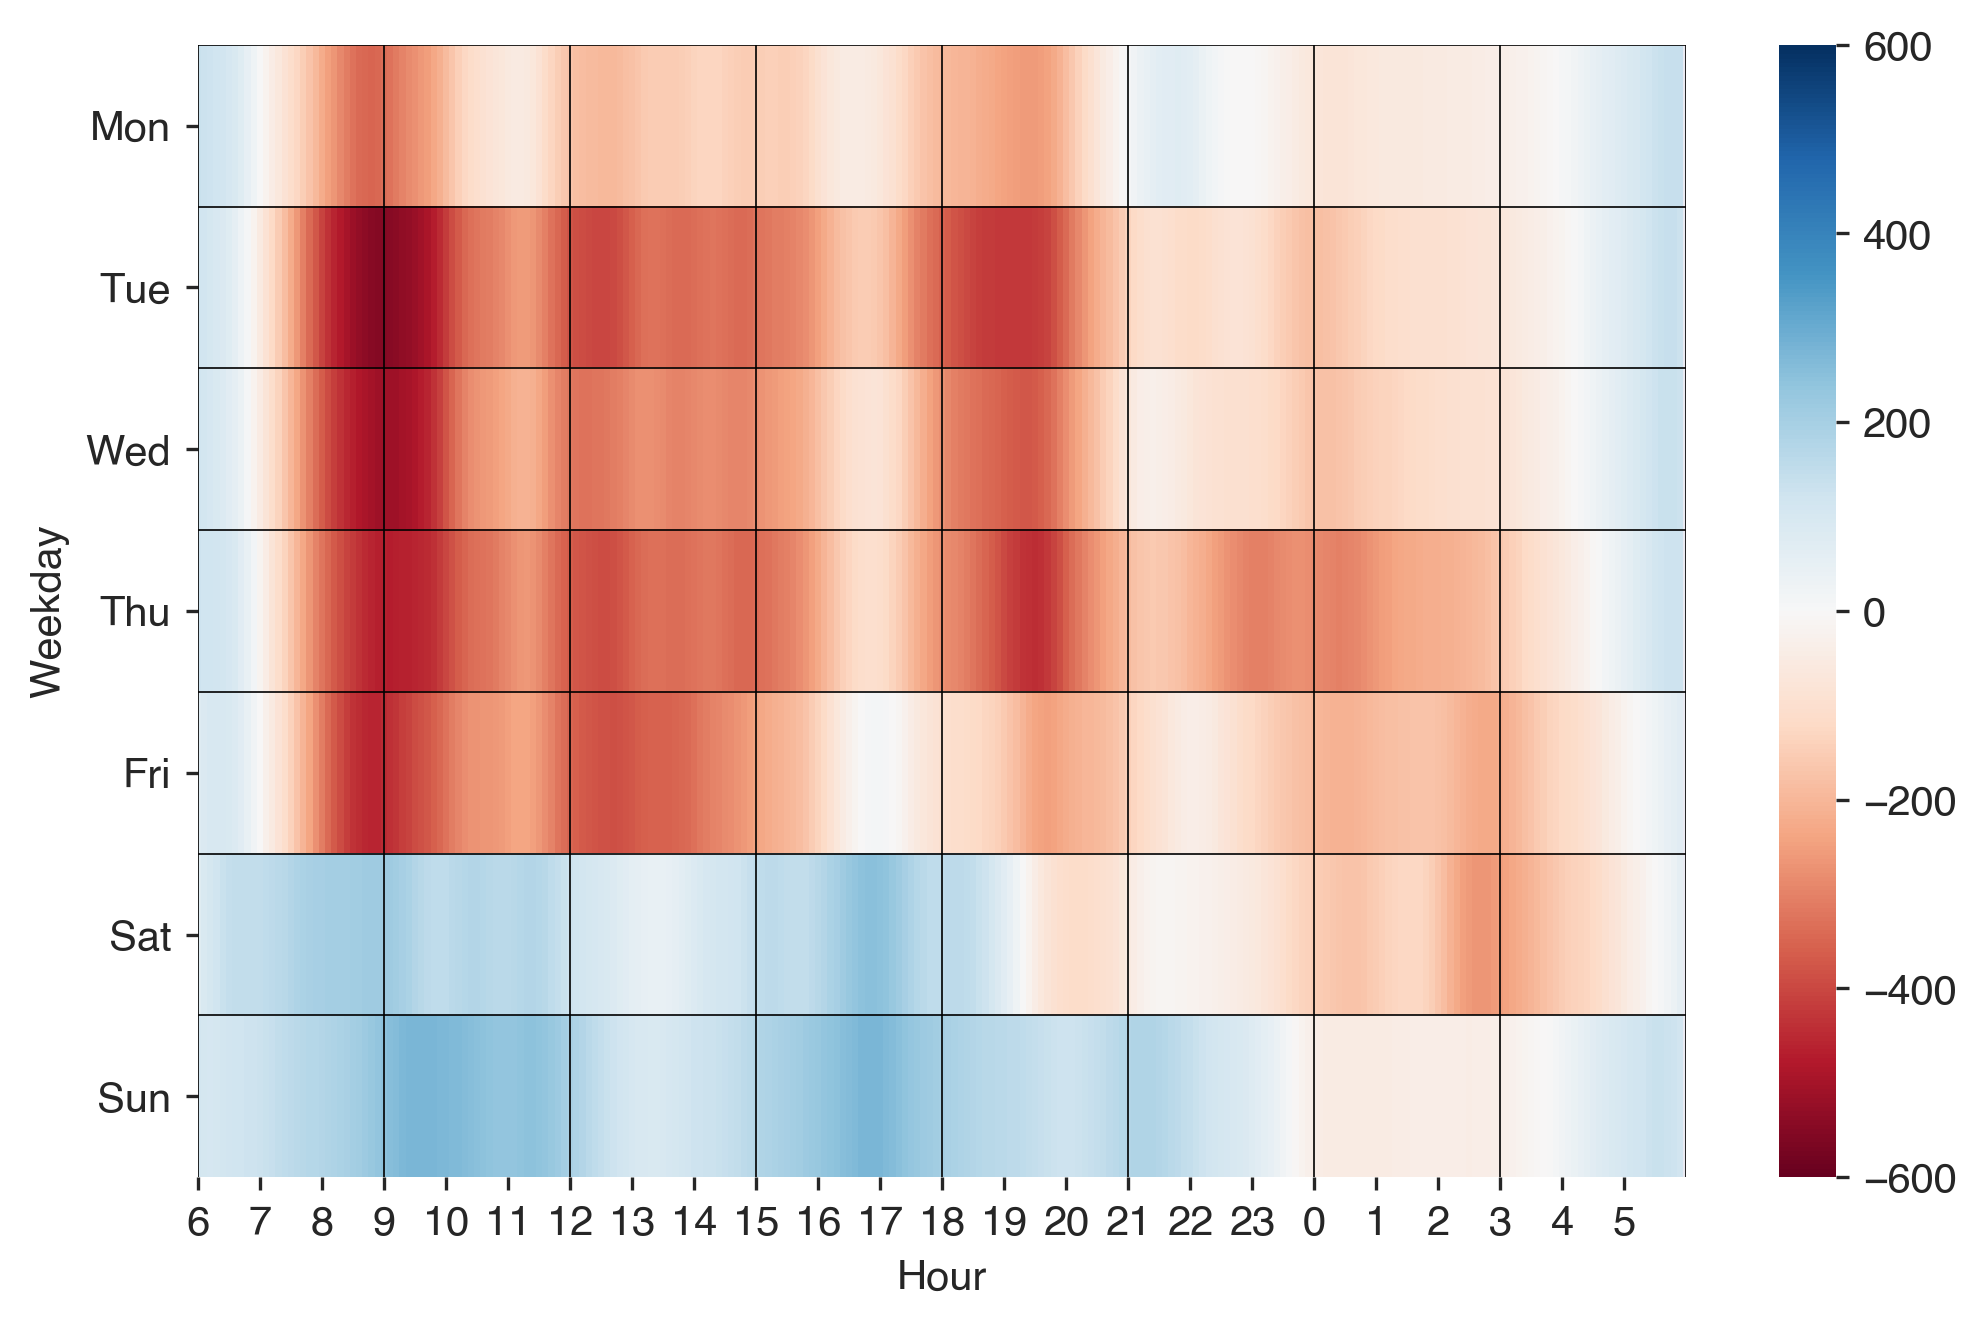

In [162]:
plt.imshow(pickup_trends_smoothed, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-600, vmax=600)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

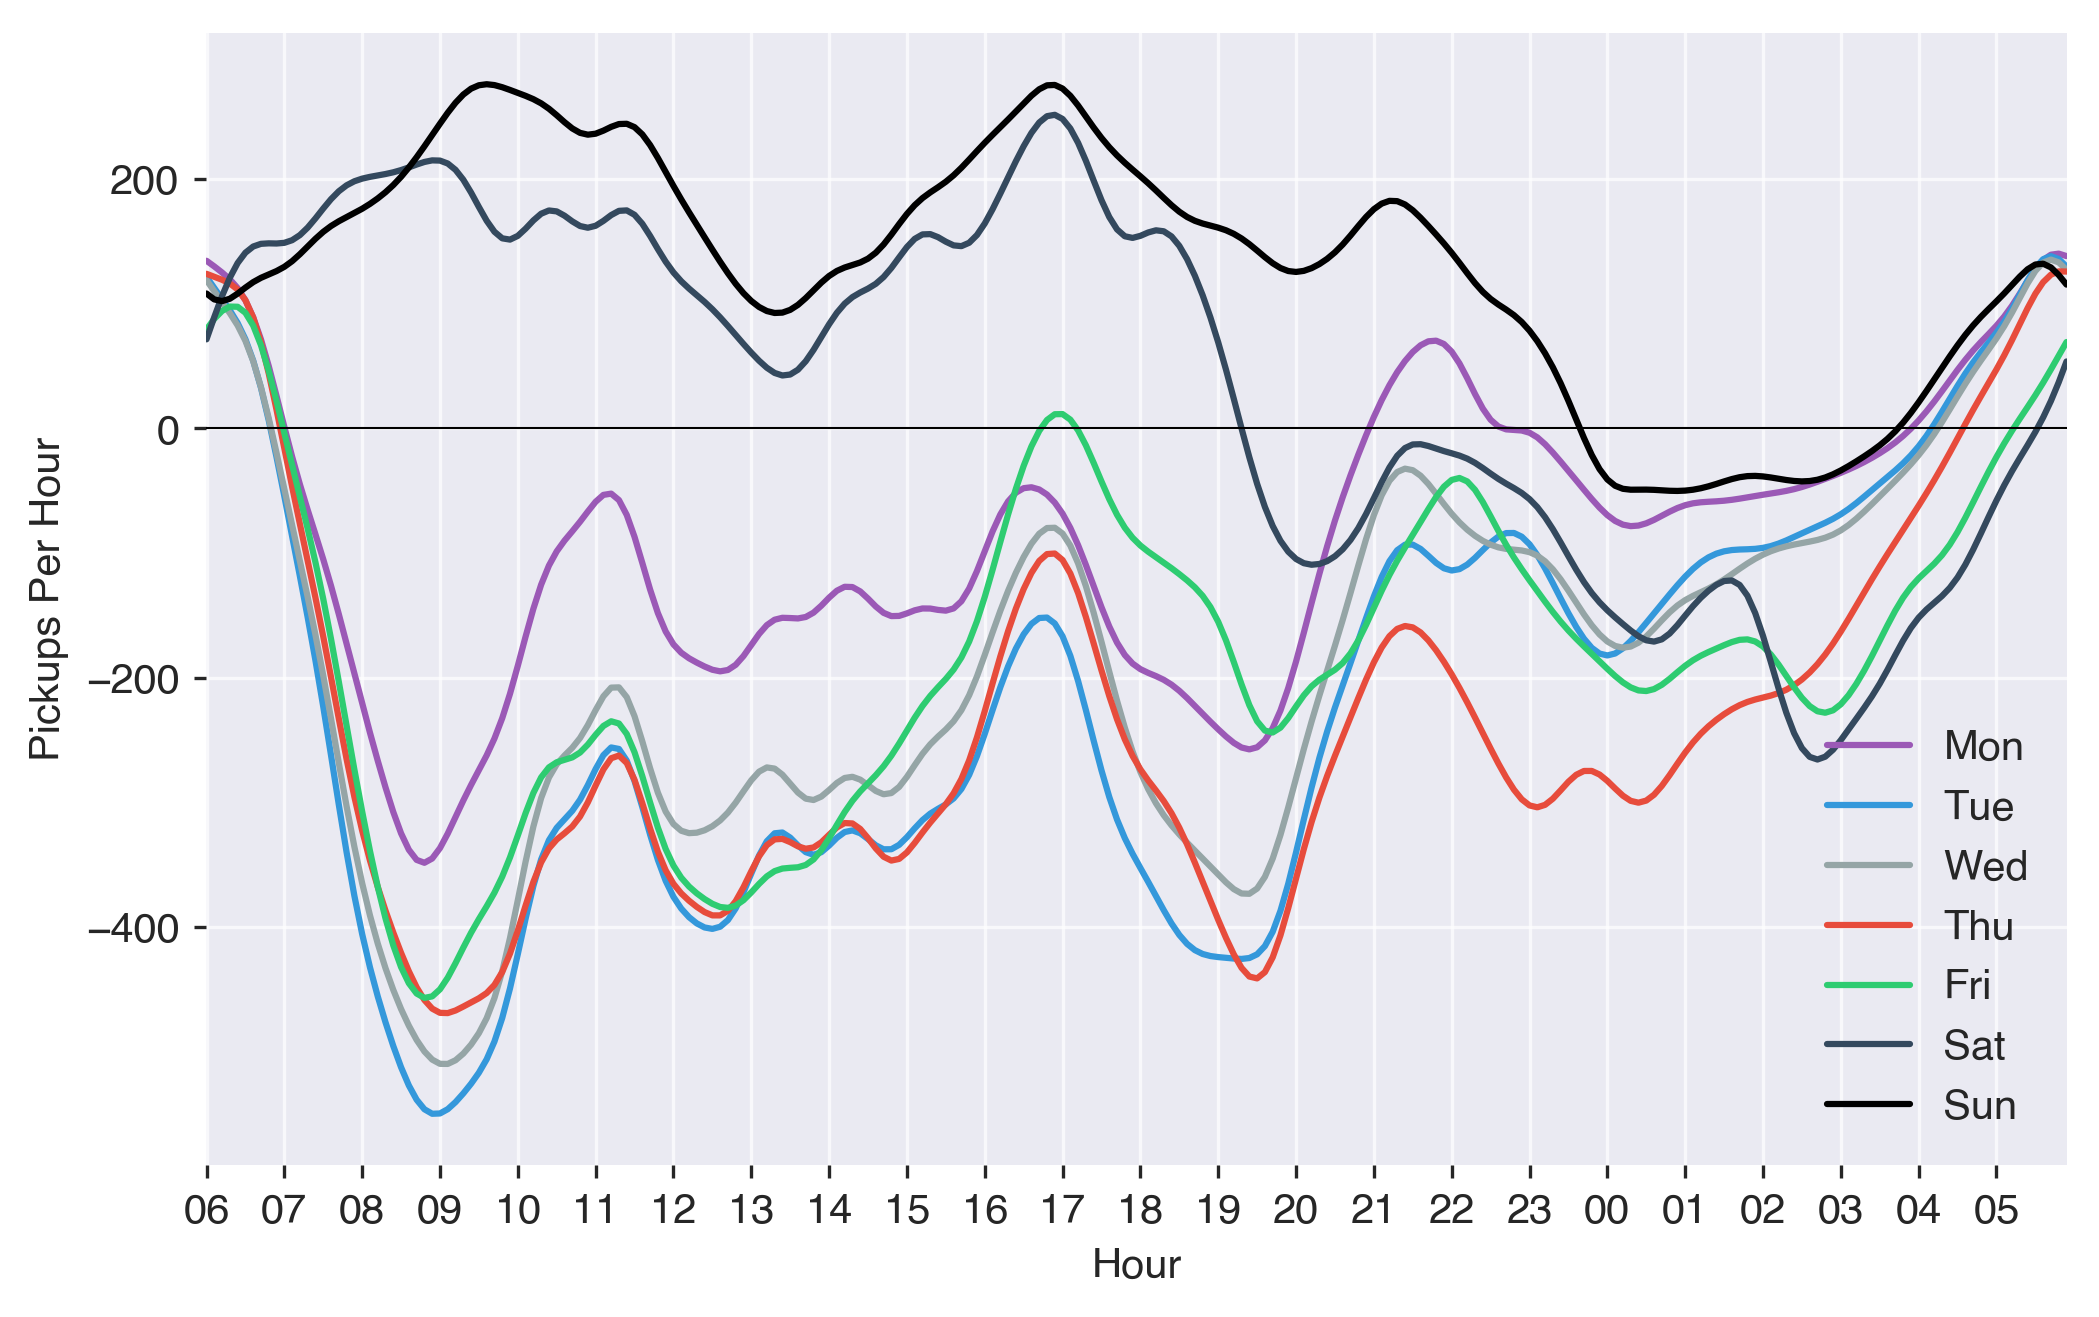

In [163]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, (pickup_trends_smoothed)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='lower right')

plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))

plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")

(0, 240)

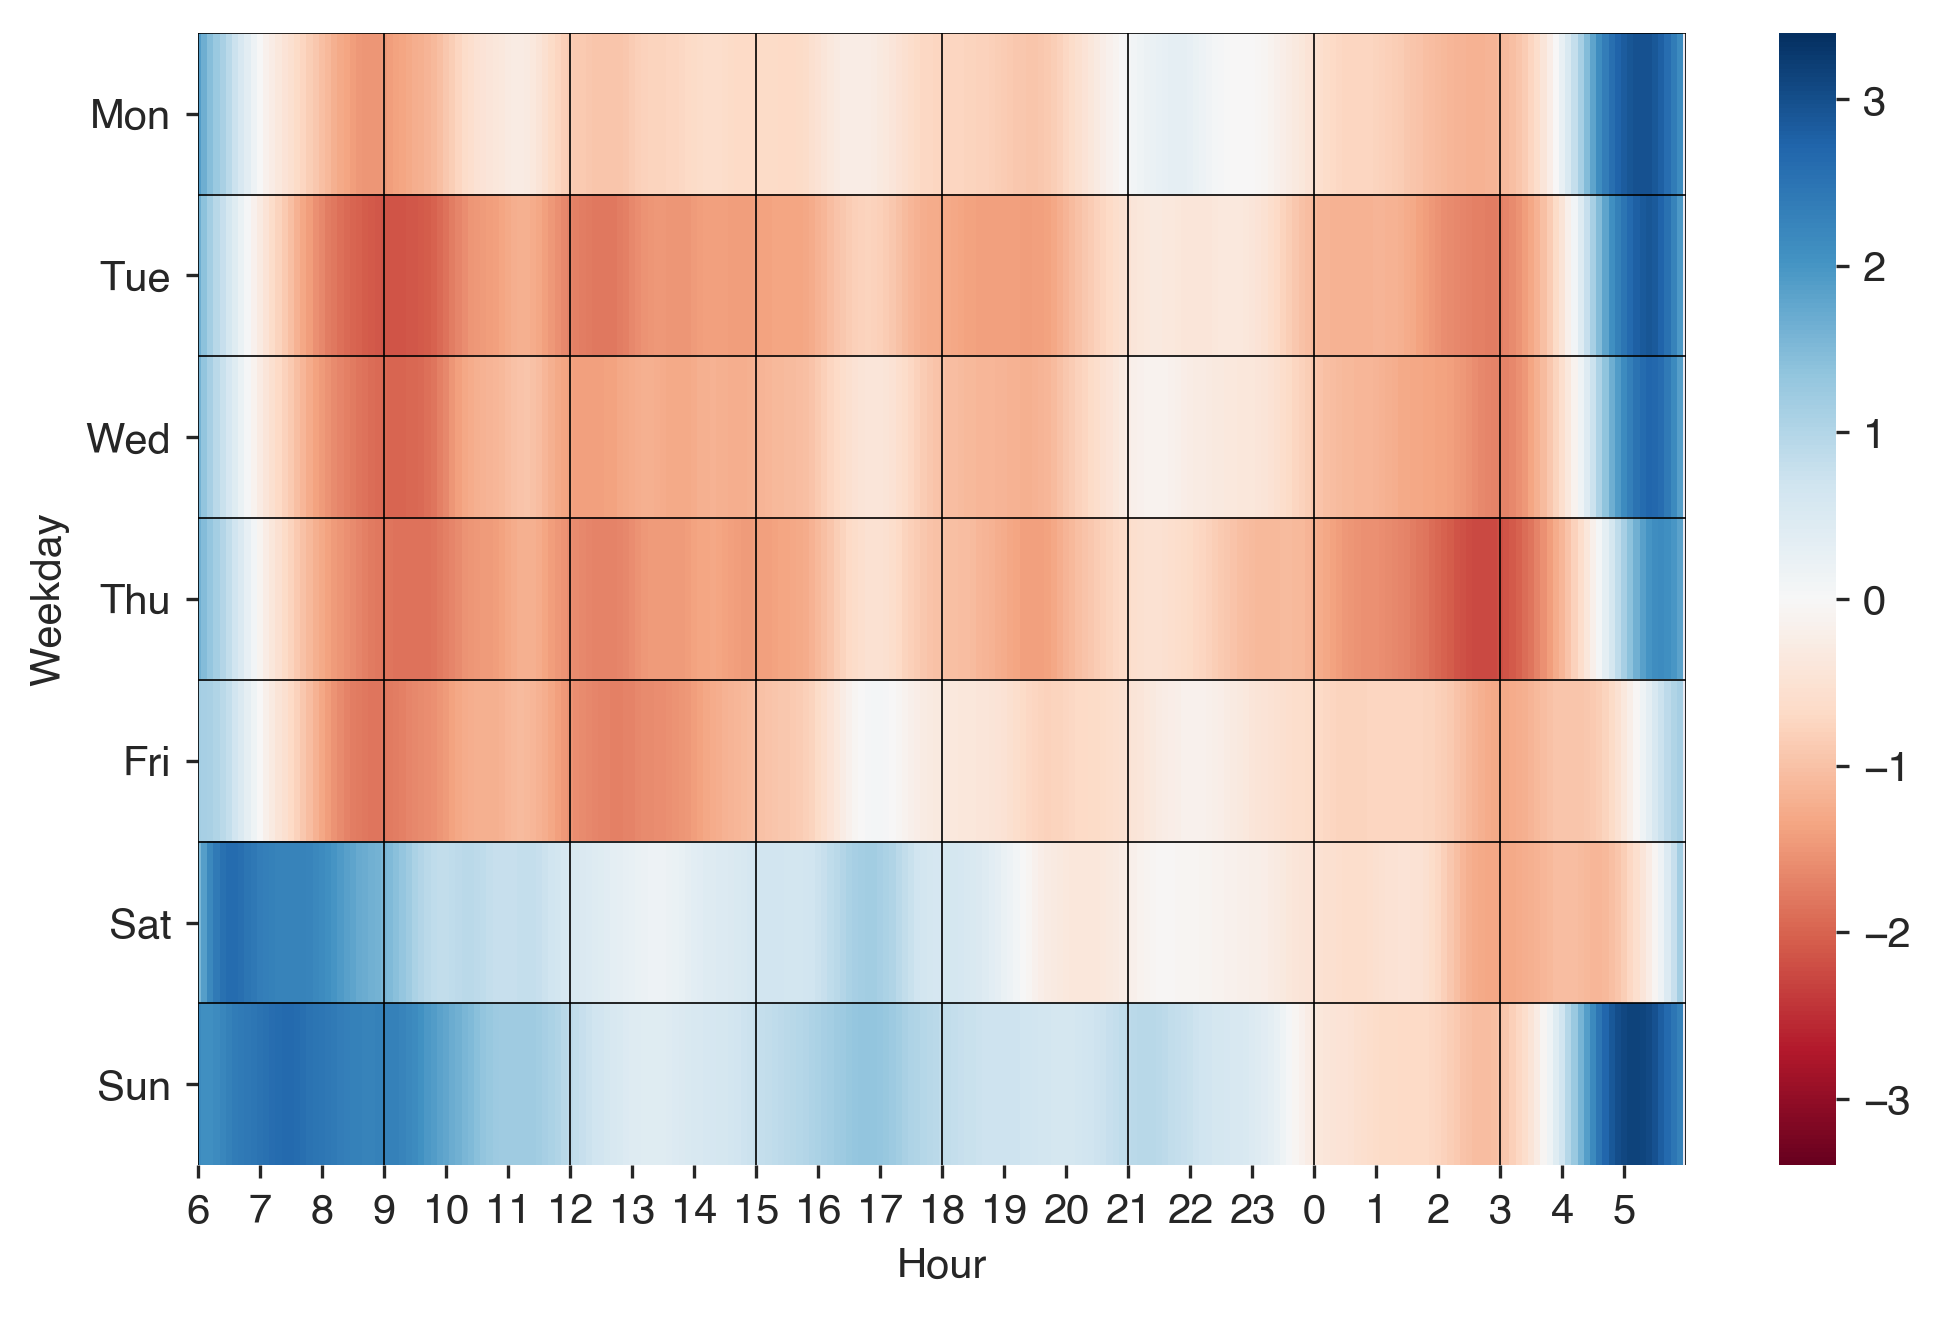

In [165]:
percentage_change = pickup_trends_smoothed/pickup_counts_smoothed*100
# percentage_change[pickup_trends_pvalue > 0.05] = 0.

plt.imshow(percentage_change, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-3.4, vmax=3.4)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

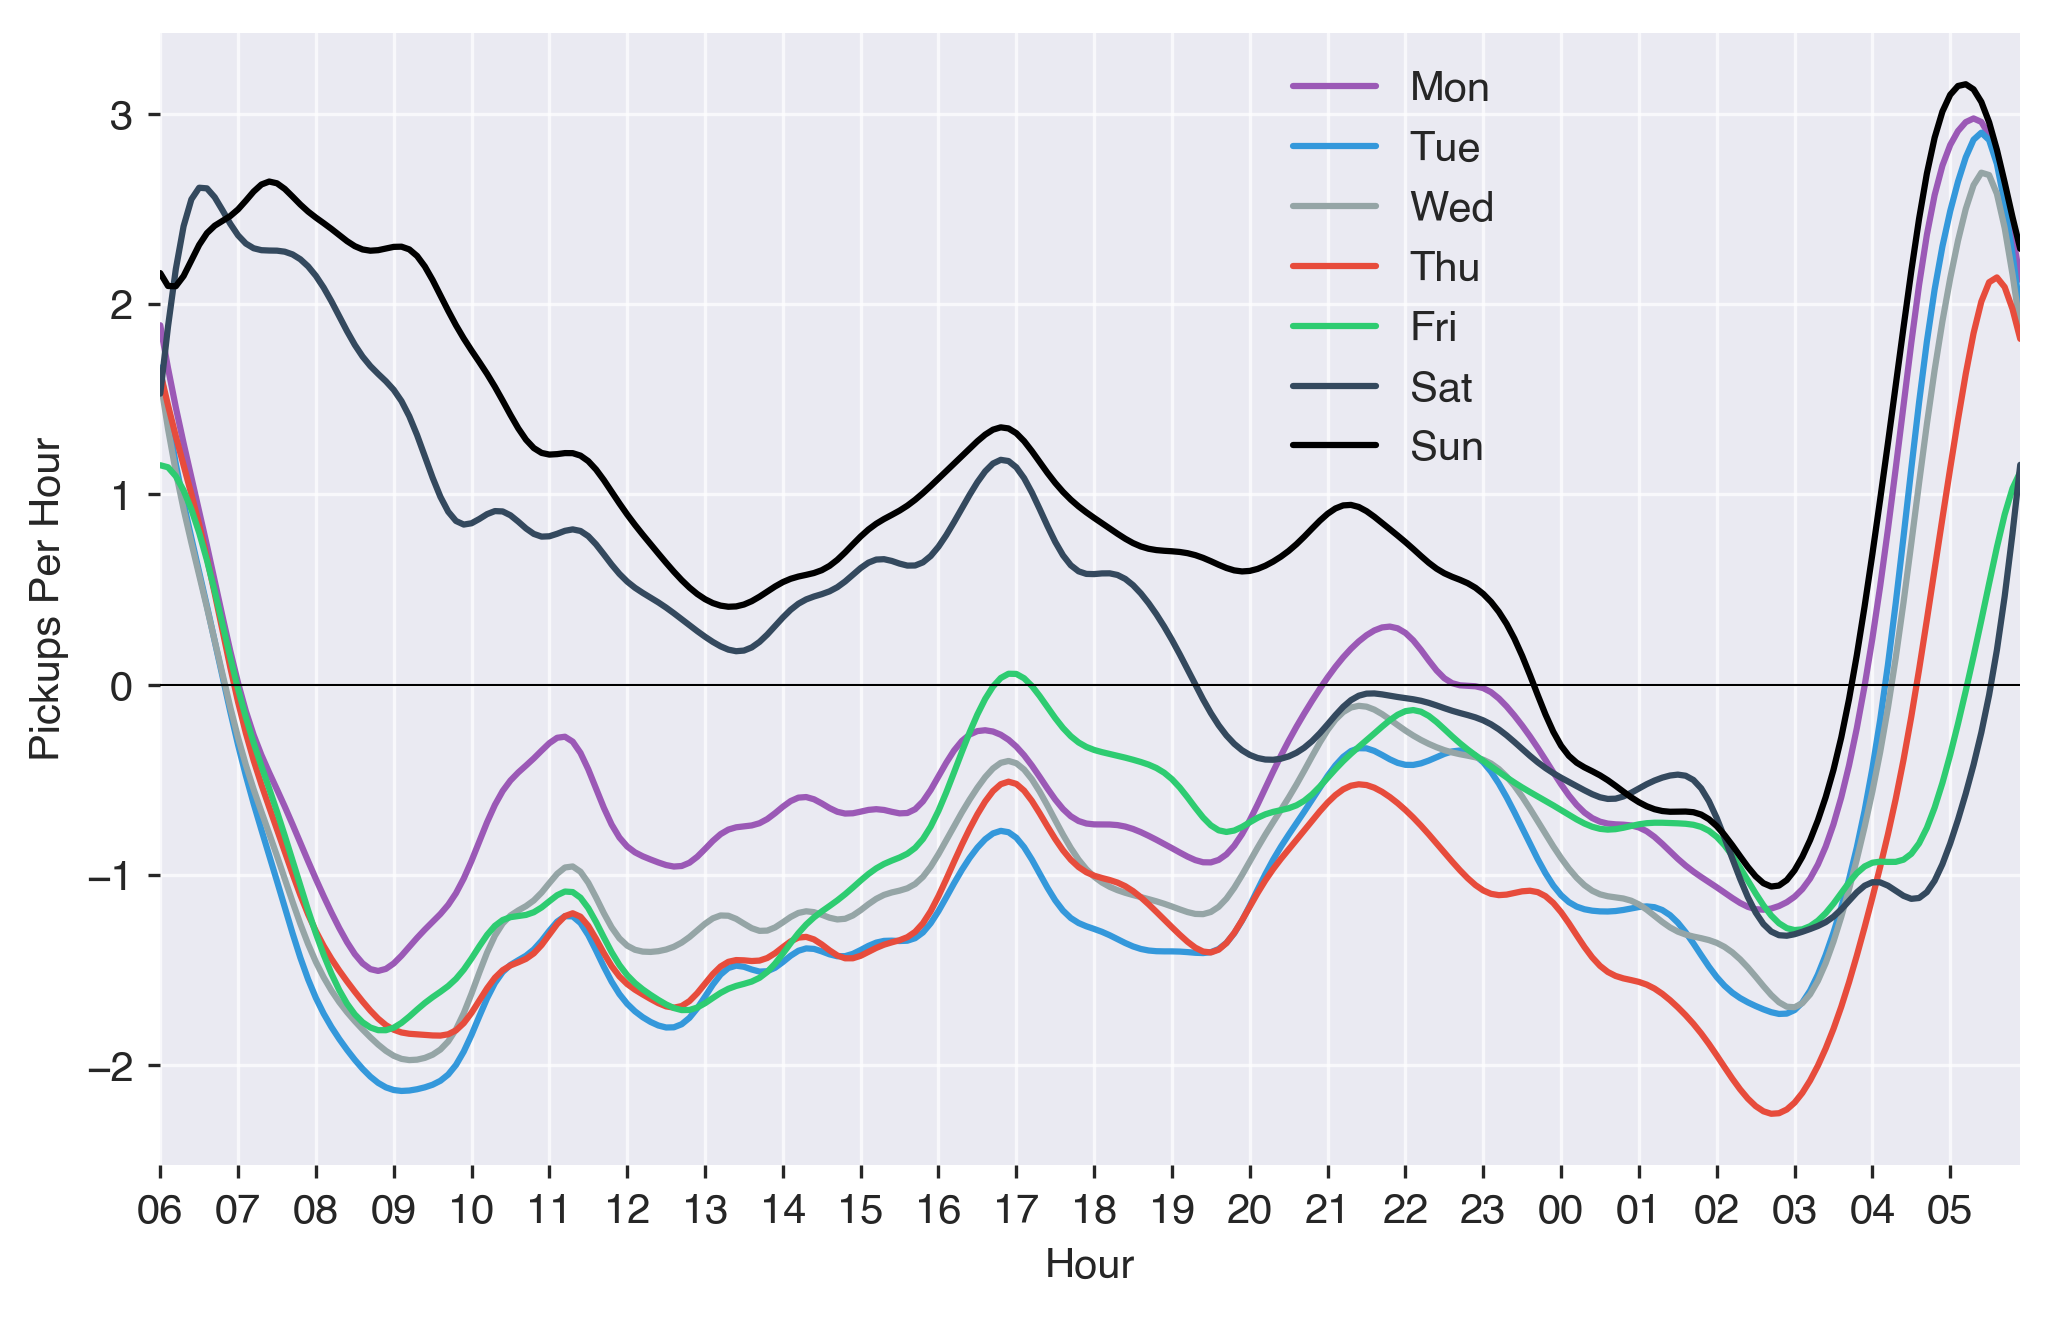

In [172]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, percentage_change[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc=(0.6, 0.6))
# plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))
# plt.ylim(0, 37000)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")

# Dropoff Trends

In [173]:
heatmap_all_dropoffs_all = (dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']] \
                            .groupby(['dayofweek', 'timeofday', 'weeks_since_2009']).count().compute())

In [174]:
import statsmodels.api as sm

In [192]:
grouped2 = heatmap_all_dropoffs_all.reset_index().groupby(['dayofweek', 'timeofday'])

rows2 = []

for group in grouped2.groups.keys():
    df = grouped2.get_group(group)
    df['constant']=1
    X = df[['weeks_since_2009','constant']]
    y = df['id']
    model = sm.OLS(y,X)
    results = model.fit()
    
    rows2.append(group + (results.params.weeks_since_2009, results.params.constant, 
                         results.rsquared_adj, results.pvalues.weeks_since_2009))


/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


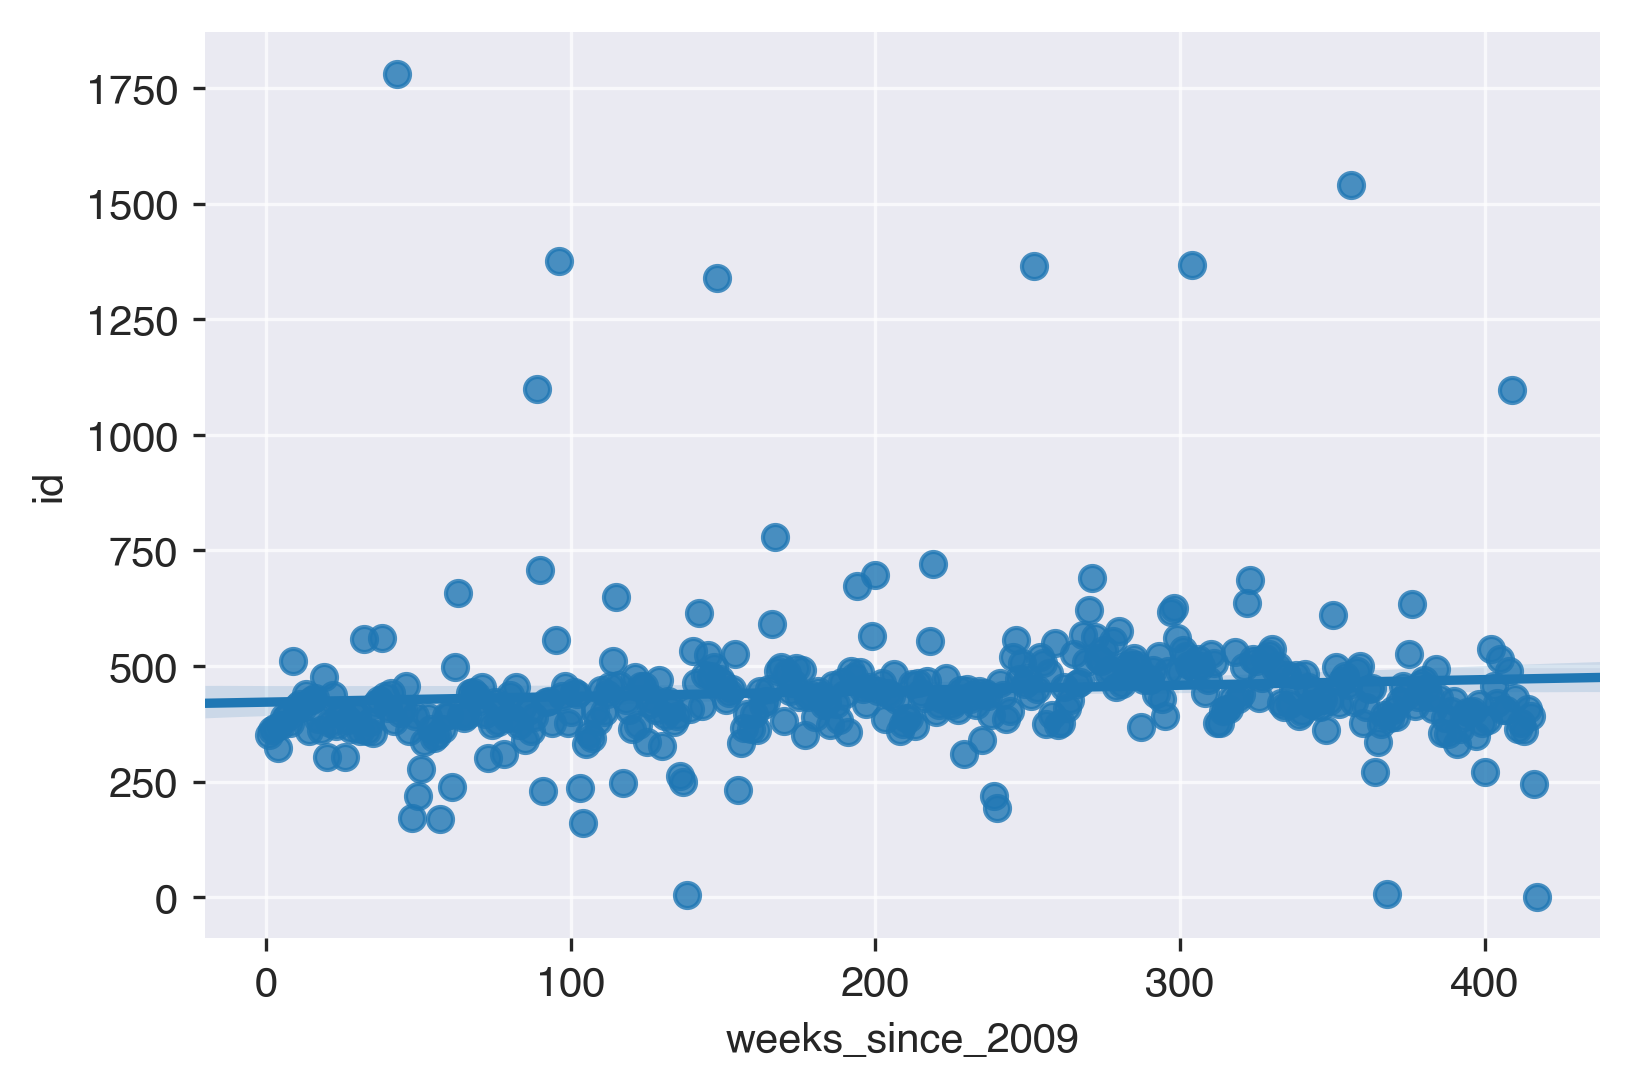

In [193]:
d0 = grouped2.get_group((6, 6.5)).reset_index(drop=True)
# d0 = d0[d0.weeks_since_2009>-2]
sns.regplot(d0.weeks_since_2009, d0.id)

In [194]:
df_dropoff_trend_slopes = pd.DataFrame.from_records(
    rows2, columns=['dayofweek', 'timeofday', 'slope', 'intercept', 'rsq_adj', 'pvalue']
                                                  ).sort_values(['dayofweek', 'timeofday'])

In [195]:
dropoff_trends = np.zeros((7, 240), dtype=np.float32) 
dropoff_trends_rsq_adj = np.zeros((7, 240), dtype=np.float32)
dropoff_trends_pvalue = np.zeros((7, 240), dtype=np.float32)

for weekday in range(7):
    dropoff_trends[weekday, :] = df_dropoff_trend_slopes[df_dropoff_trend_slopes.dayofweek == weekday].slope.values * 10 * 52 # convert units into counts per hour
    dropoff_trends_rsq_adj[weekday, :] = df_dropoff_trend_slopes[df_dropoff_trend_slopes.dayofweek == weekday].rsq_adj.values
    dropoff_trends_pvalue[weekday, :] = df_dropoff_trend_slopes[df_dropoff_trend_slopes.dayofweek == weekday].pvalue.values
    
dropoff_trends = np.roll(dropoff_trends.ravel(), -60).reshape(dropoff_trends.shape)
dropoff_trends_rsq_adj = np.roll(dropoff_trends_rsq_adj.ravel(), -60).reshape(dropoff_trends_rsq_adj.shape)
dropoff_trends_pvalue = np.roll(dropoff_trends_pvalue.ravel(), -60).reshape(dropoff_trends_pvalue.shape)

In [196]:
dropoff_trends_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    dropoff_trends.ravel(), sigma=2, axis=-1, mode='wrap').reshape(dropoff_trends.shape)
dropoff_counts_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    dropoff_counts.ravel(), sigma=2, axis=-1, mode='wrap').reshape(dropoff_counts.shape)

(0, 240)

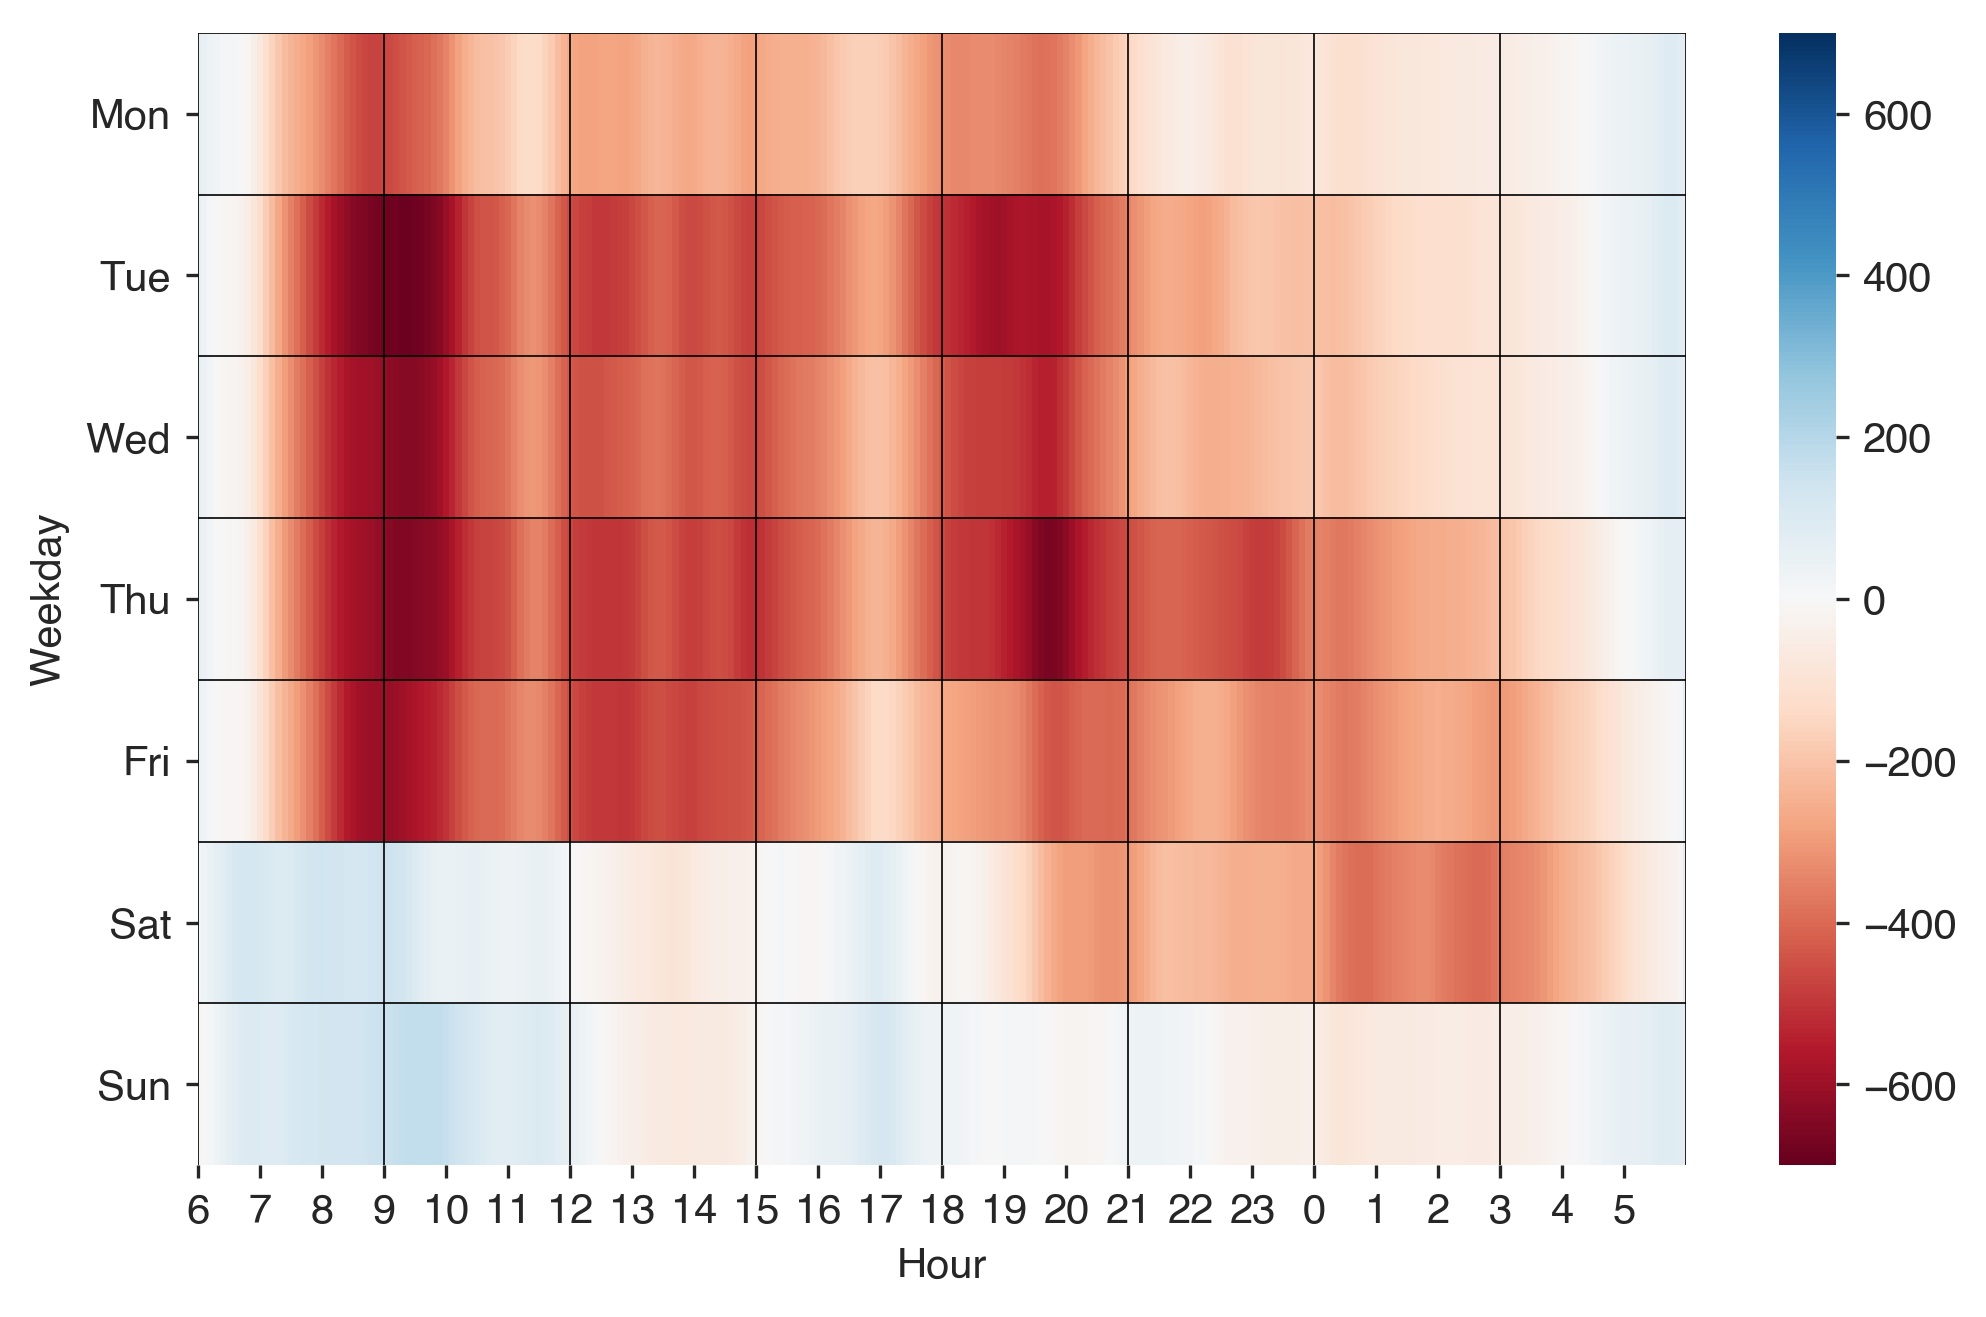

In [197]:
plt.imshow(dropoff_trends_smoothed, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-700, vmax=700)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

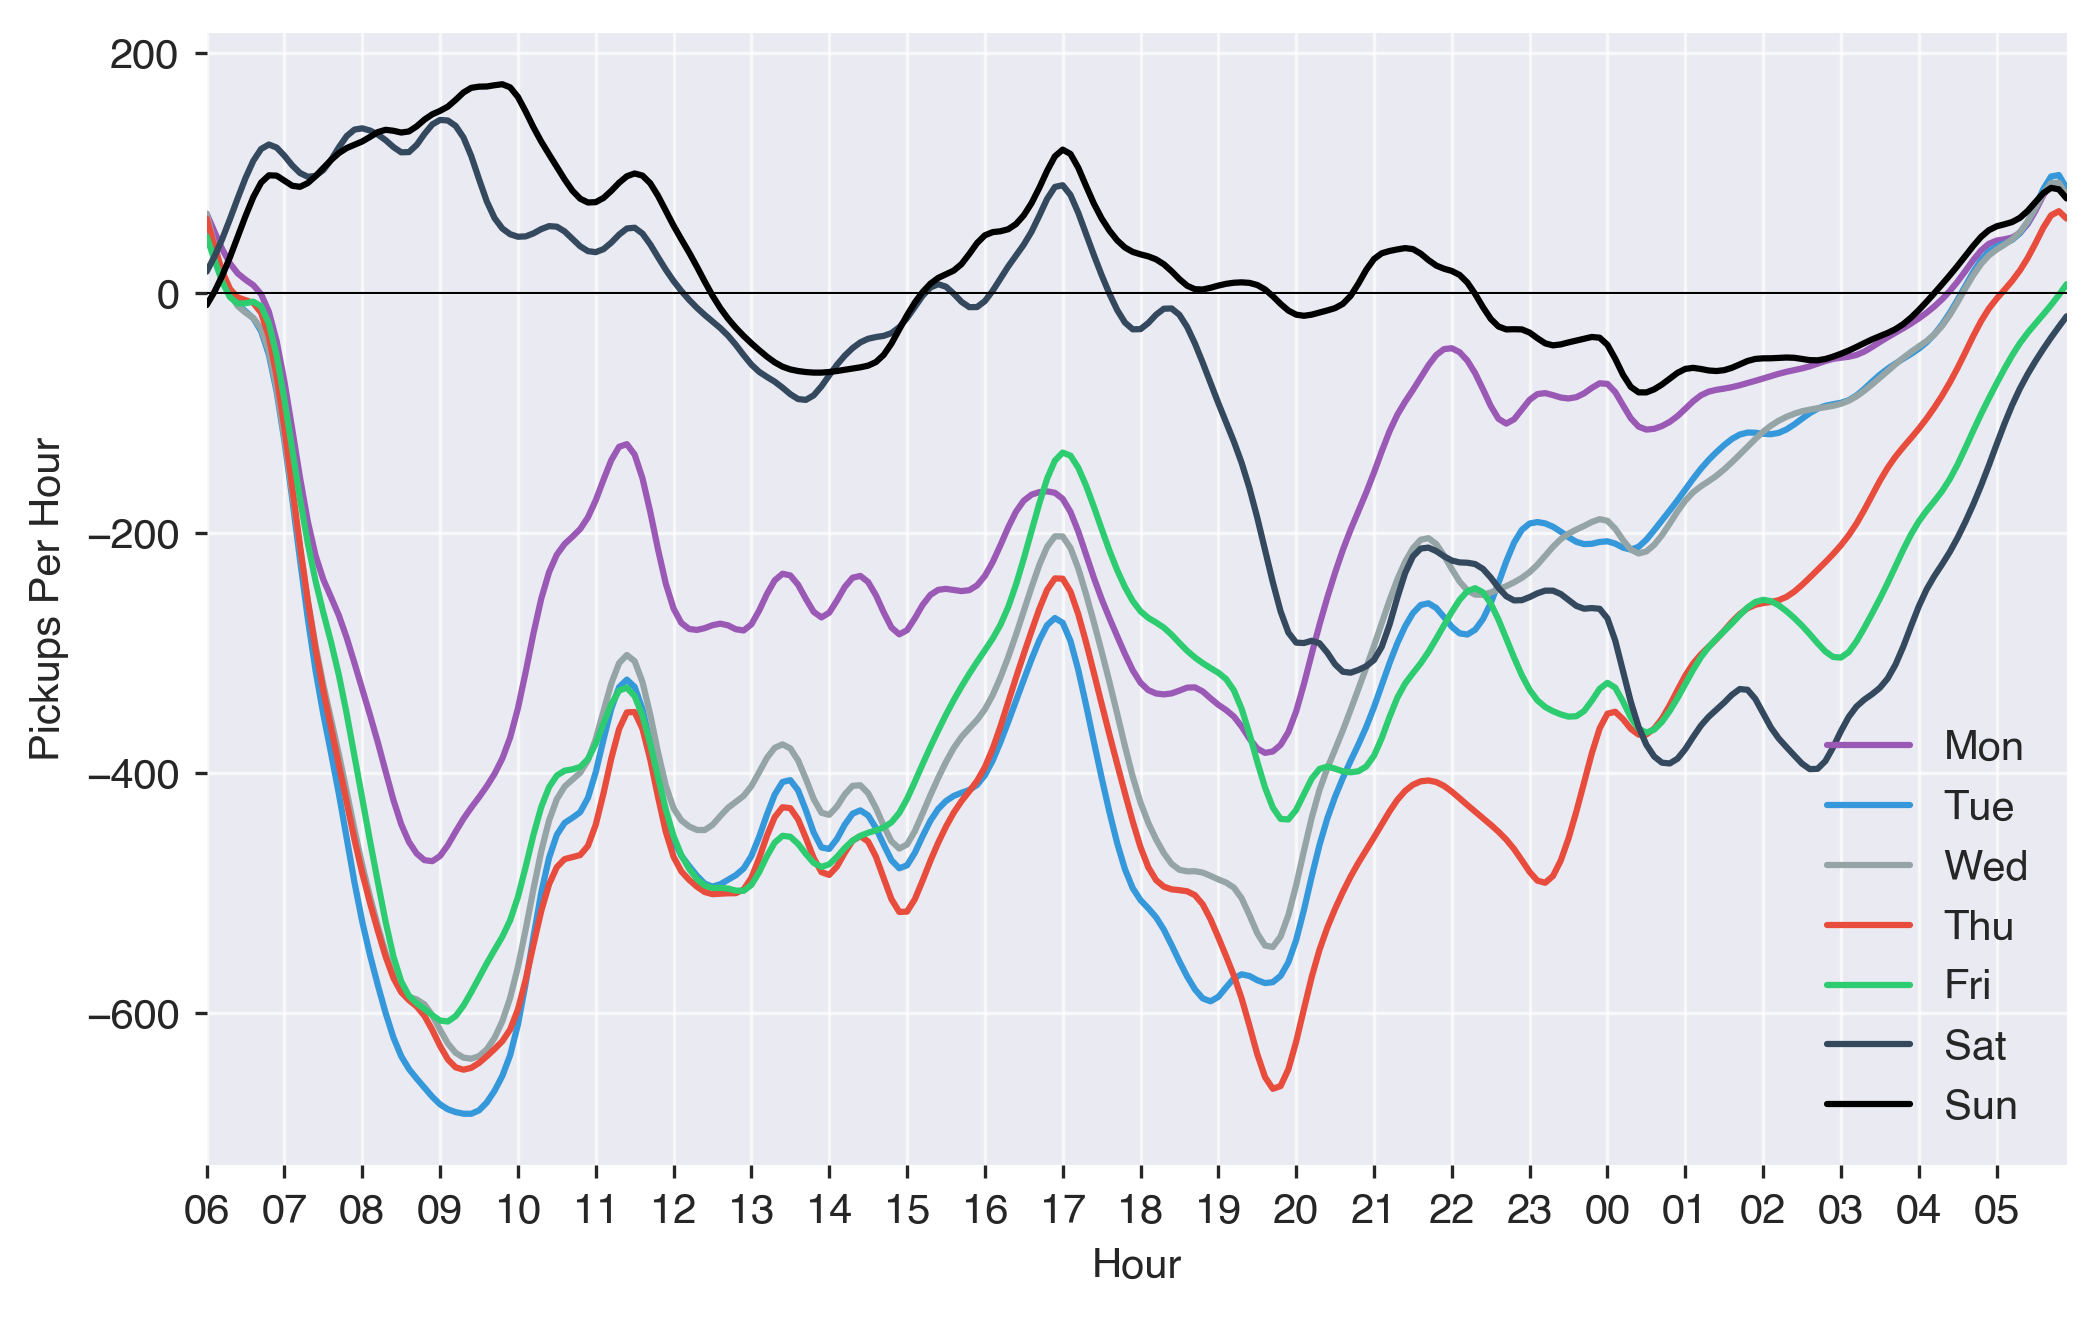

In [198]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, (dropoff_trends_smoothed)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='lower right')

plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))

plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")

(0, 240)

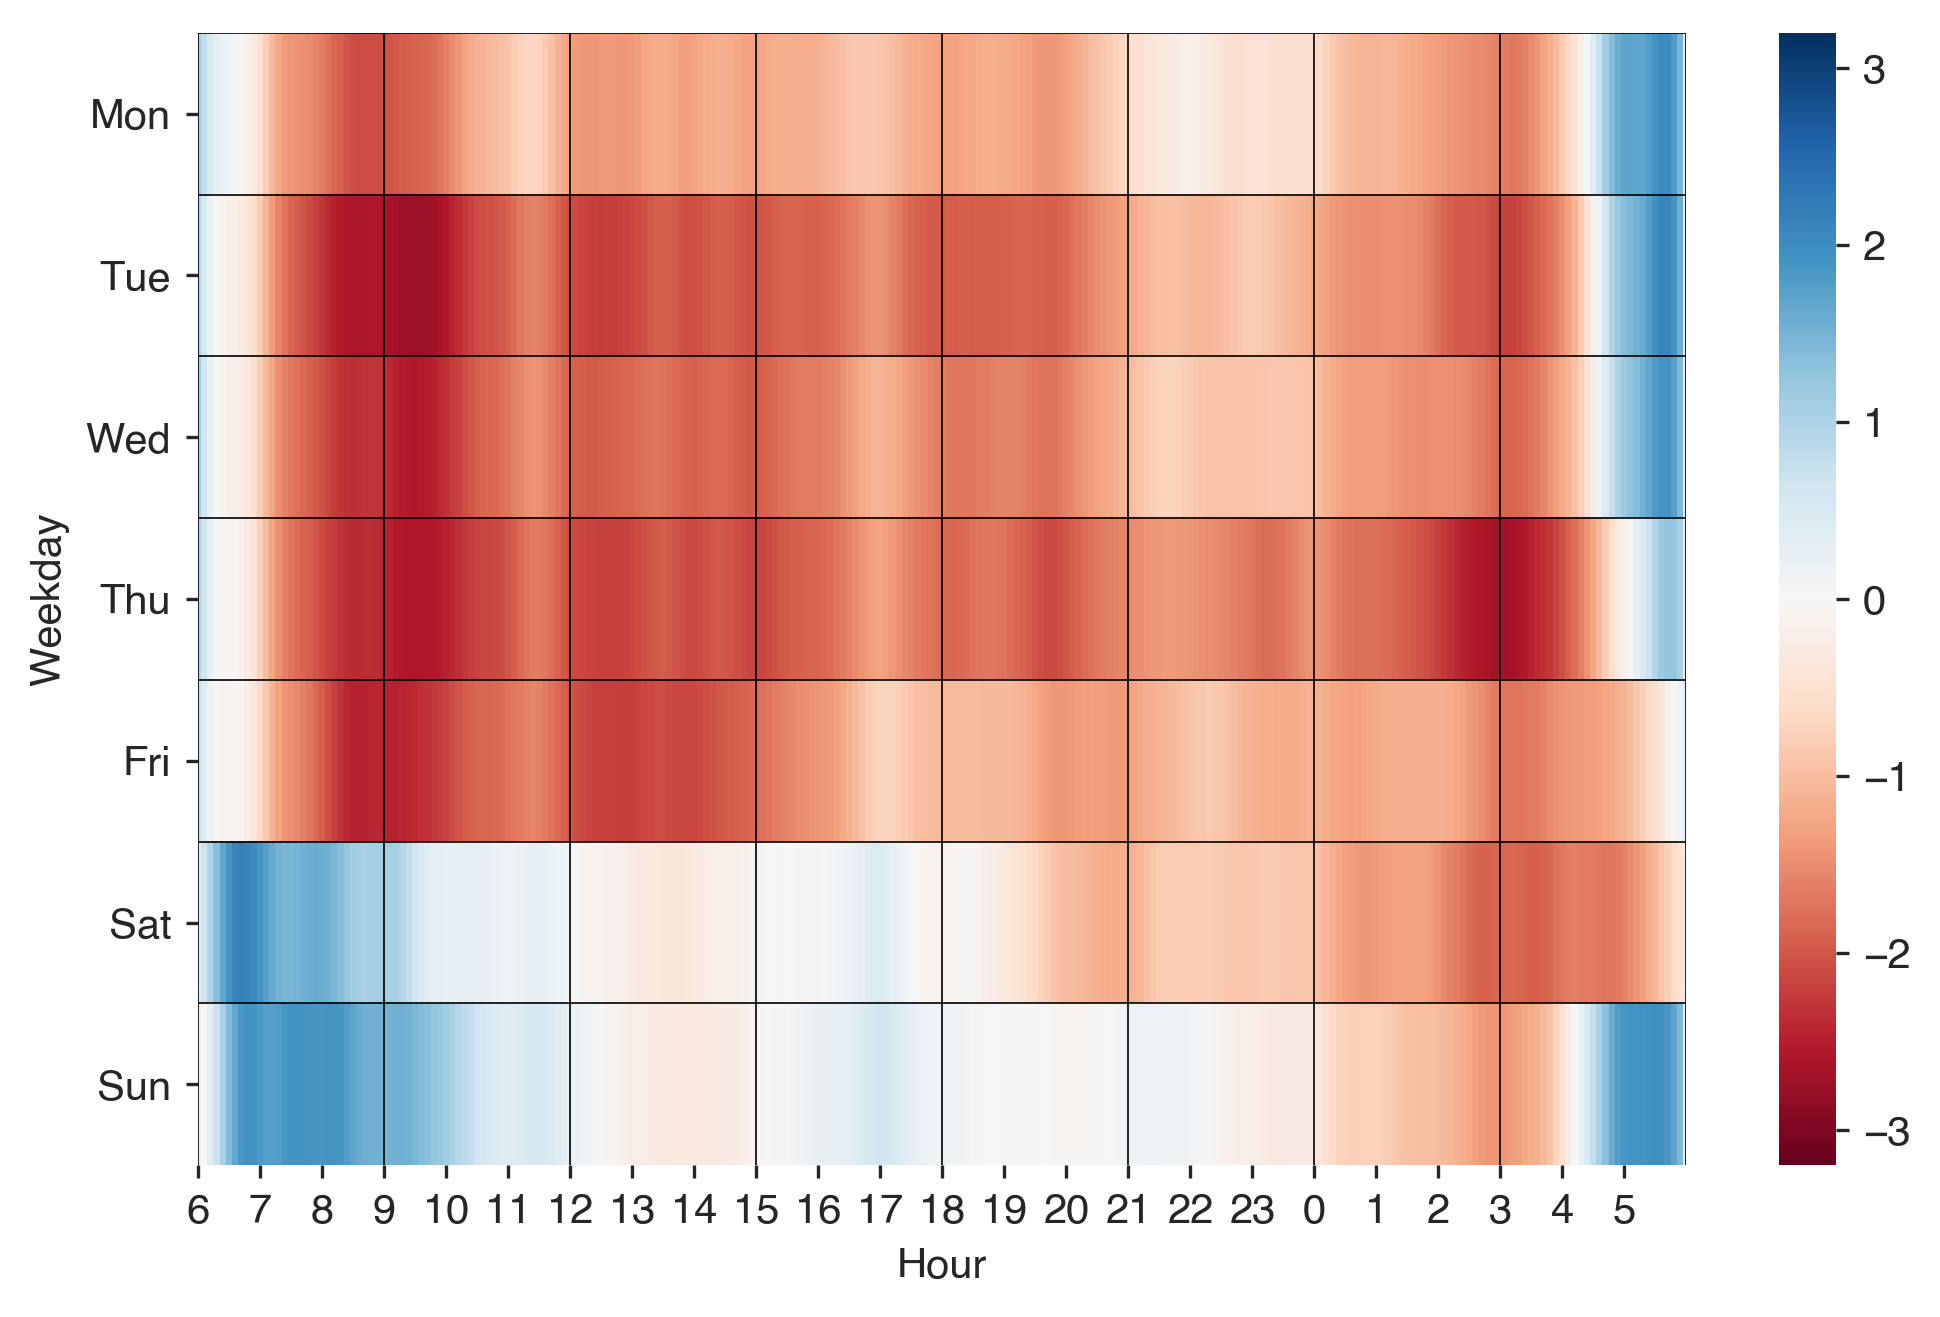

In [199]:
percentage_change_dropoff = dropoff_trends_smoothed/dropoff_counts_smoothed*100

plt.imshow(percentage_change_dropoff, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-3.2, vmax=3.2)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

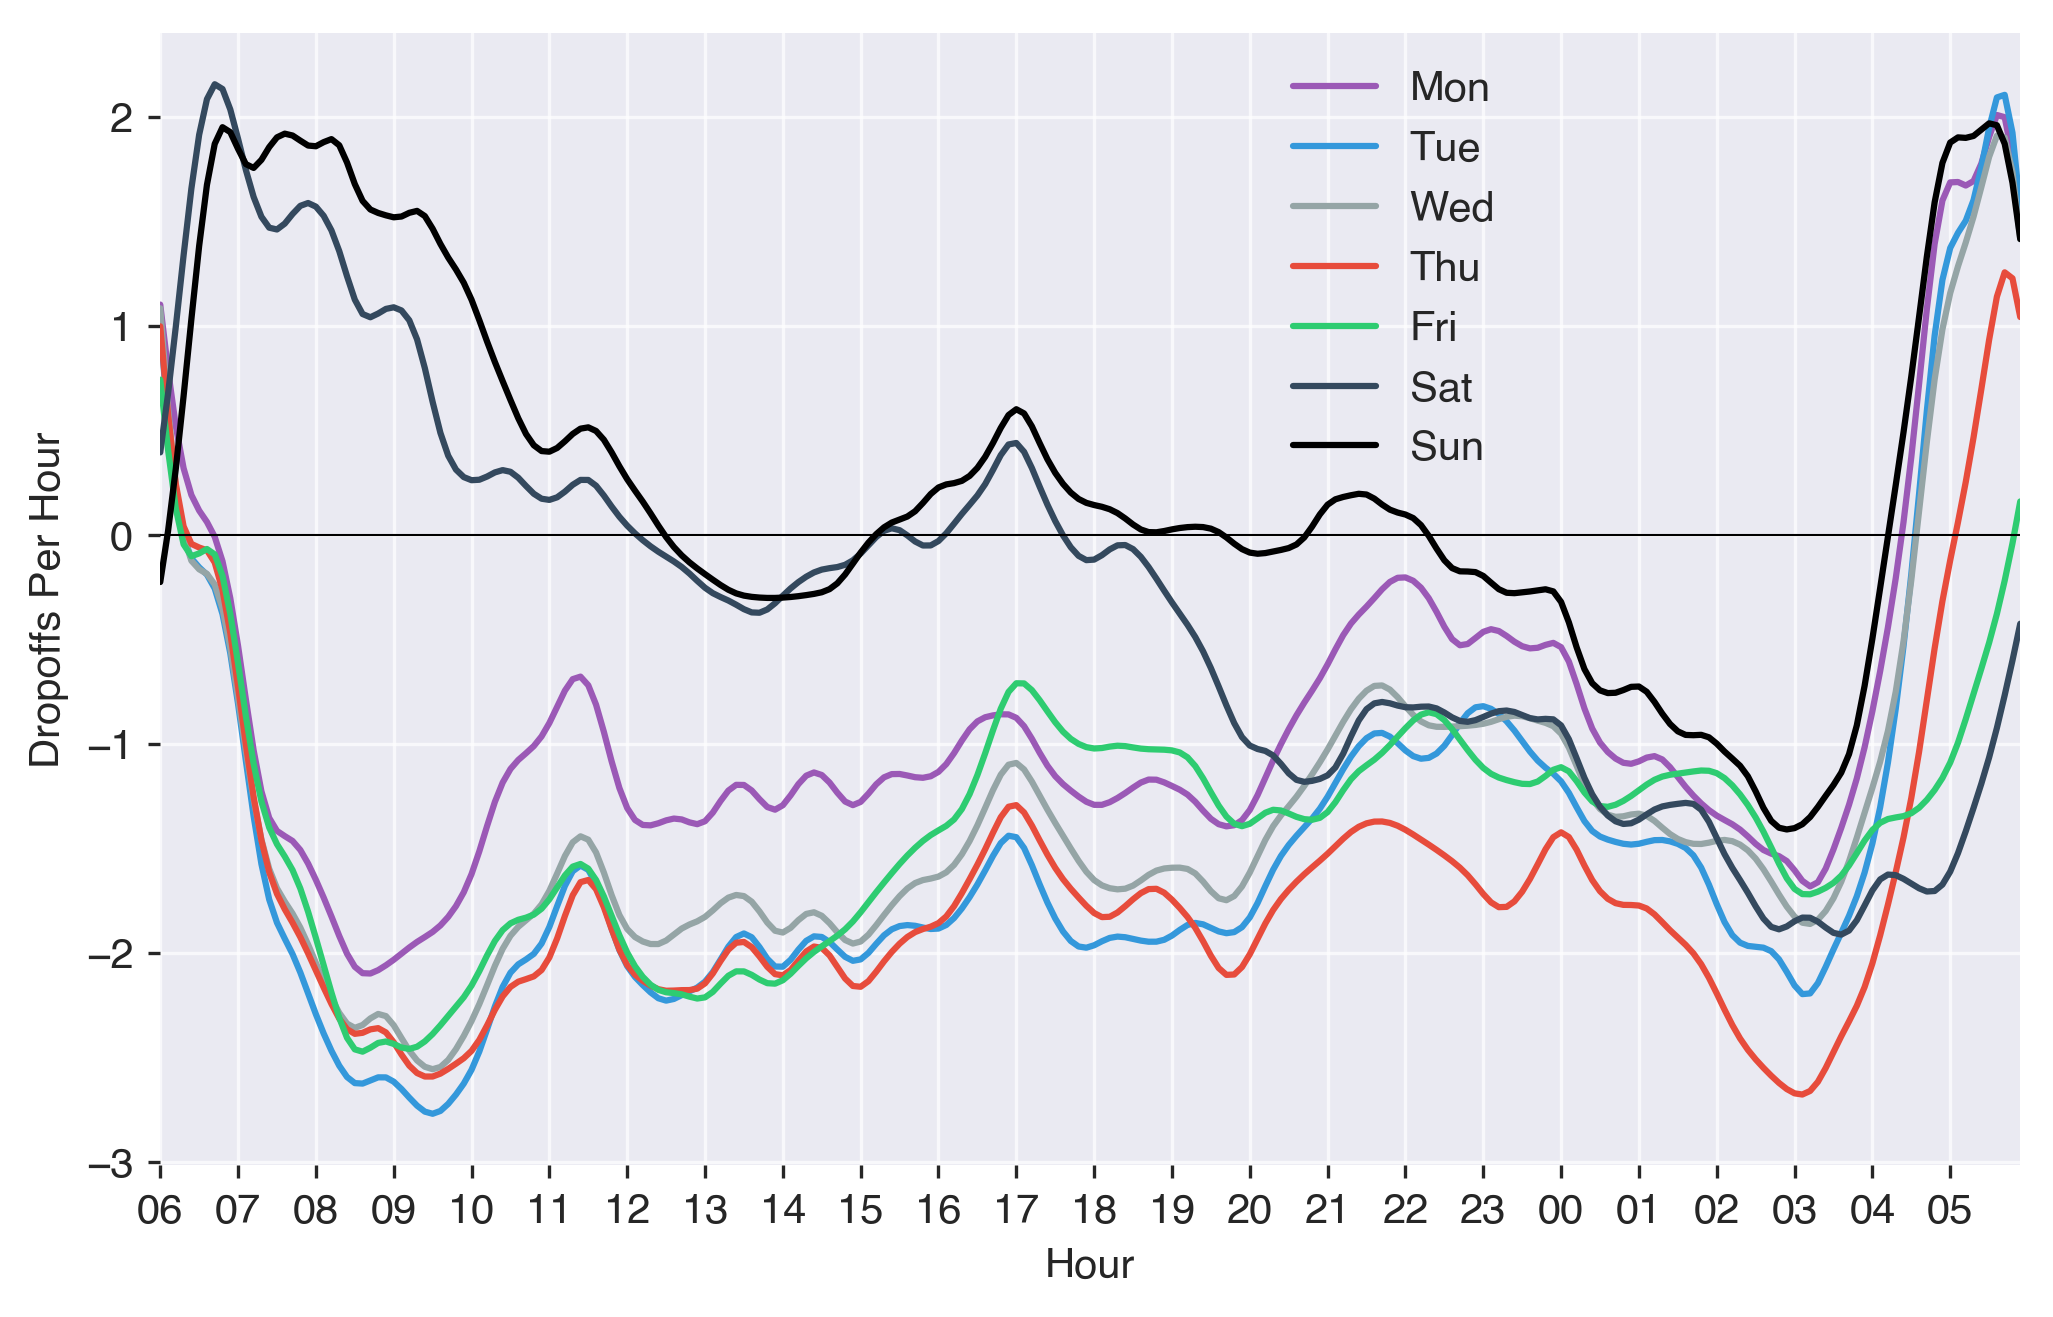

In [201]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, percentage_change_dropoff[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc=(0.6, 0.6))
# plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))
# plt.ylim(0, 37000)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Dropoffs Per Hour")